# Helper Function

In [ ]:
"""
This module contains all the functions that define the kernels
"""
import numpy as np
import matplotlib.pyplot as plt
import torch


def full_kernel_classic(x, y):
    """
    Classical evaluation of the full kernel
    :param x: arg 1
    :param y: arg 2
    :return:
    """
    k = 1
    for i in range(len(x)):
        k = k * np.cos(1/2*(x[i]-y[i]))**2
    return k


def kernel_matrix_classic(X, Y):
    """
    compute the kenel matrix of the full kernel
    :param X: vector of samples
    :param Y: vector of samples
    :return:
    """
    K = np.zeros((len(X), len(Y)))
    for i in range(len(X)):
        for j in range(len(Y)):
            K[i, j] = full_kernel_classic(X[i], Y[j])
    return K


def kernel_matrix_classic_torch(X, Y):
    """
    compute the kenel matrix of the full kernel potentially utilizing some parallel processing
    :param X: vector of samples
    :param Y: vector of samples
    :return:
    """
    if type(X) is np.ndarray:
        X = torch.from_numpy(X)
    if type(Y) is np.ndarray:
        Y = torch.from_numpy(Y)
    # create tensor with entry i x j x k equal to x_ik - y_jk
    X = X.unsqueeze(1).expand(-1, Y.size(0), -1)
    Y = Y.unsqueeze(0).expand(X.size(0), -1, -1)
    K = X - Y
    K = torch.cos(K / 2) ** 2
    K = torch.prod(K, 2)
    return K



In [ ]:
import numpy as np

class GaussianProcessRegressor:
    """
    Gaussian Process Regressor for d-dimensional inputs.
    Returns both predictive mean and std if requested.
    """
    def __init__(self, kernel, alpha=1e-5):
        self.kernel = kernel
        self.alpha = alpha
        self.X_train = None
        self.y_train = None
        self.K_inv = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.X_train = X
        self.y_train = y
        K = self.kernel(X, X)
        K += self.alpha * np.eye(len(X))
        self.K_inv = np.linalg.inv(K)

    def predict(self, X_test, return_std=False):

        X_test = np.array(X_test)
        K_star = self.kernel(X_test, self.X_train)
        y_mean = K_star @ (self.K_inv @ self.y_train)

        if return_std:
            K_star_star = self.kernel(X_test, X_test)
            cov = K_star_star - K_star @ self.K_inv @ K_star.T
            var = np.diag(cov)
            var = np.maximum(var, 0.0)
            y_std = np.sqrt(var)
            return y_mean, y_std
        else:
            return y_mean


In [ ]:
from itertools import product

# def build_grid(bounds, n_grid):
#     """
#     Build a uniform grid of points within the given 'bounds'.

#     Parameters
#     ----------
#     bounds : list of (low, high) for each dimension (length d)
#     n_grid : int
#         Number of grid points per dimension.

#     Returns
#     -------
#     X_grid : np.ndarray of shape (n_grid^d, d)
#         All points in the grid.
#     """
#     # For each dimension, create an array of n_grid points from low to high
#     axes = [np.linspace(low, high, n_grid) for (low, high) in bounds]
#     # Cartesian product of all axes
#     # e.g. for d=2, we get all pairs (x,y); for d=3, all (x,y,z), etc.
#     mesh = list(product(*axes))  # a list of d-tuples
#     return np.array(mesh)

def build_grid(bounds, n_grid, random_state=None):
    """
    Draw n_grid^d random points uniformly from the given 'bounds'.

    Parameters
    ----------
    bounds : list of (low, high) for each dimension (length d)
        Defines a d-dimensional box in which to sample points.
    n_grid : int
        We will create exactly n_grid^d random points in total.
    random_state : int or None
        Optional seed for reproducibility.

    Returns
    -------
    X_rand : np.ndarray of shape (n_grid^d, d)
        The random points in the domain.
    """
    np.random.seed(None)

    d = len(bounds)
    n_points = n_grid ** d  # total number of random points
    X_rand = np.zeros((n_points, d))

    for i in range(n_points):
        for j in range(d):
            low, high = bounds[j]
            X_rand[i, j] = np.random.uniform(low, high)

    return X_rand


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.stats import norm



def gp_ucb_nd(
    f,                 # black-box reward function, shape: (n, d) -> (n,)
    gp,                # a GaussianProcessRegressor instance (fit, predict)
    bounds,            # list of (low, high) for each dimension
    n_iter=10,         # number of UCB iterations
    init_points=3,     # number of initial random samples
    n_grid=50,         # number of grid points per dimension to search for UCB max
    beta_func=None,    # a callable or None => we define a default
    random_state=None,
    error = 1,
    verbose=False
):
    """
    Runs GP-UCB for a multi-armed bandit / Bayesian optimization problem.

    Parameters
    ----------
    f : callable
        The unknown reward function (black-box).
        Input shape (n, d) -> (n,) for n points in dimension d.
    gp : GaussianProcessRegressor
        Surrogate GP model implementing:
          - gp.fit(X, y)
          - gp.predict(X, return_std=True) -> (mean, std)
    bounds : list of (low, high)
        Domain bounding box in d dimensions.
    n_iter : int
        Number of GP-UCB rounds.
    init_points : int
        How many random points to sample initially.
    n_grid : int
        Grid resolution for selecting x_t = argmax_x [mu_{t-1}(x) + sqrt(beta_t)*sigma_{t-1}(x)].
    beta_func : callable or None
        If None, we define a simple default that grows with t.  Otherwise,
        something like:  beta_func(t) -> float
    random_state : int or None
        For reproducibility.
    verbose : bool
        Print iteration details if True.

    Returns
    -------
    regrets : ndarray of shape (n_iter + init_points,)
        Cumulative regret at each iteration (the sum over t=1..T of [f(x*) - f(x_t)]).
    X_samples : ndarray of shape (n_iter + init_points, d)
    Y_samples : ndarray of shape (n_iter + init_points,)

    Notes
    -----
    - We assume we can approximate the global max f(x*) by a dense grid search
      once, for regret calculation.  In a real bandit scenario, you might not
      know x*, but for synthetic tests or known benchmark functions, we do.
    - The domain is searched by a grid of size (n_grid^d).  This is only feasible
      for small d or moderate n_grid.
    """

    if random_state is not None:
        np.random.seed(random_state)

    d = len(bounds)

    # 1) Create a dense grid to:
    #    - approximate x* (the global maximizer)
    #    - search for the UCB argmax each iteration
    X_grid = build_grid(bounds, n_grid=n_grid)  # shape (n_grid^d, d)

    # 2) (Optional) approximate the global maximum for regret calculation
    #    We take the best among the same grid points to get x_star
    Y_grid = f(X_grid)
    idx_best = np.argmax(Y_grid)
    x_star = X_grid[idx_best]
    f_star = Y_grid[idx_best]  # approximate global max value

    # 3) Helper to define a default beta_t if user didn't supply one
    if beta_func is None:
        # E.g. a common choice for finite domain or small bounding
        # can be something like: 2 ln(t^2 * pi^2 / (6 delta))
        # but we just do a simpler scaling of log t for demonstration.
        def beta_func(t):
            return 2.0 * np.log(1000 * t**2 * 10 / 6 / 0.1 )   # delta = 0.1
    # else user supplies something like beta_func(t) => some formula

    # 4) Initialize data by sampling 'init_points' random points
    def sample_random(n):
        return np.array([
            [np.random.uniform(low, high) for (low, high) in bounds]
            for _ in range(n)
        ])

    X_samples = sample_random(init_points)  # shape (init_points, d)
    Y_samples = f(X_samples)               # shape (init_points,)

    # 5) We'll keep track of cumulative regrets
    regrets = np.zeros(n_iter + init_points)
    # First 'init_points' regrets are computed from those random picks
    # Evaluate the regret at each step
    cum_regret = 0.0
    for i in range(init_points):
        cum_regret += (f_star - Y_samples[i])
        regrets[i] = cum_regret

    # 6) Main loop of GP-UCB
    log_sum_for_beta = 0
    for step in range(n_iter):

        X_grid = build_grid(bounds, n_grid=n_grid)

        t = init_points + step + 1  # total iteration index (1-based)

        # Fit GP on current data
        gp.fit(X_samples, Y_samples)

        # Compute mean & std on the entire grid
        mu_grid, std_grid = gp.predict(X_grid, return_std=True)

        # Define current beta_t
        beta_t = 0.1 * (2*np.log(20)+log_sum_for_beta) ** 0.5 + 3

        #beta_func(t)

        # UCB = mu + sqrt(beta_t) * std
        ucb_values = mu_grid + (beta_t + error * np.sqrt(t) ) * std_grid

        # if step % 10 == 0:
        #   print(step)
        #   print(mu_grid[:10], std_grid[:10])
        #   print(ucb_values[:10])
        #   #print(np.max(ucb_values))
        #   print("==========")

        # Argmax on the grid
        idx_next = np.argmax(ucb_values)
        x_next = X_grid[idx_next].reshape(1, -1)

        log_sum_for_beta += np.log(1 + std_grid[idx_next])

        #print(beta_t + error * np.sqrt(t) )
        #print(std_grid[idx_next])

        # Evaluate the unknown function f (bandit feedback)
        np.random.seed(None)
        noise = np.random.normal(0, 0.1)
        y_true = f(x_next)
        y_next = y_true + noise
        #print(noise)

        # Update data
        X_samples = np.vstack([X_samples, x_next])
        Y_samples = np.concatenate([Y_samples, y_next])

        # Update cumulative regret
        cum_regret += (f_star - y_true[0])
        regrets[init_points + step] = cum_regret

        if verbose:
            print(f"Iteration {step+1}/{n_iter}, t={t}, beta={beta_t:.3f}, "
                  f"x_next={x_next[0]}, f(x)={y_next[0]:.4f}, UCB={ucb_values[idx_next]:.4f}, "
                  f"CumReg={cum_regret:.4f}")

    return regrets, X_samples, Y_samples





import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

def run_multiple_experiments_gp_ucb(
    f,
    gp,
    bounds,
    n_runs=5,
    n_iter=10,
    init_points=3,
    n_grid=50,
    beta_func=None,
    random_state=None,
    error = 1,
    verbose=False
):
    """
    Runs the GP-UCB experiment 'n_runs' times, each time creating a new GP instance.
    Returns the average cumulative regret across runs.

    Parameters
    ----------
    f : callable
        The black-box reward function.
    gp_class_factory : callable
        A function that, when called, returns a *new* untrained GaussianProcessRegressor
        (or similar). For example:
          lambda: GaussianProcessRegressor(kernel=RBF(...), alpha=..., optimizer=None)
        We need a fresh GP for each run, so that each run is independent.
    bounds : list of (low, high)
        Domain bounding box.
    n_runs : int
        Number of independent runs to average over.
    n_iter : int
        Number of GP-UCB rounds (not counting the init_points).
    init_points : int
        Number of random initial points in each run.
    n_grid : int
        Grid resolution for argmax search in each run.
    beta_func : callable or None
        If None, use a default log-based. Otherwise a function beta_func(t) -> float.
    random_state : int or None
        For reproducibility. If set, seeds the first run's RNG, then subsequent runs
        will shift the seed.
    verbose : bool
        Whether to print details for each run.

    Returns
    -------
    avg_regret : ndarray of shape (n_iter + init_points,)
        The pointwise average of the cumulative regret across runs.
    regrets_all : ndarray of shape (n_runs, n_iter + init_points)
        The individual run's cumulative-regret curves.
    """

    from copy import deepcopy

    # If we want reproducibility, set base seed
    base_seed = random_state if random_state is not None else None

    # We'll store the regret curve for each run here
    regrets_all = []

    for i in trange(n_runs, desc="GP-UCB Experiments"):
        # For each run, optionally shift the seed
        if base_seed is not None:
            # shift by i to get distinct seeds
            np.random.seed(base_seed + i)

        # Create a fresh GP instance
        gp_model = gp

        # Import or copy the gp_ucb_nd from your previous code snippet:
        regrets, X_samples, Y_samples = gp_ucb_nd(
            f=f,
            gp=gp_model,
            bounds=bounds,
            n_iter=n_iter,
            init_points=init_points,
            n_grid=n_grid,
            beta_func=beta_func,
            random_state=None,  # we've set the seed externally
            error = error,
            verbose=(verbose and i == 0)  # only verbose in the 1st run, e.g.
        )

        regrets_all.append(regrets)

    regrets_all = np.array(regrets_all)  # shape (n_runs, n_steps)
    avg_regret = regrets_all.mean(axis=0)
    std_regret = regrets_all.std(axis=0)
    return avg_regret, regrets_all, std_regret





# BO with Quantum function of 5 qubits, using Grid Search to optimize Acquisition Function, Helpers also

In [ ]:
lst_of_c = np.array([1/8, 1/8,1/8,1/8,1/8,1/8,1/8,
          1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,
          1/32,1/32,1/32,1/32,1/32,1/32,1/32,1/32,
          ])
lst_of_sqrt_c = lst_of_c**0.5

lst_of_features = [lambda d0,d1,d2: np.cos(d0)/8, lambda d0,d1,d2:np.cos(d1)/8, lambda d0,d1,d2:np.cos(d2)/8,
            lambda d0,d1,d2:np.cos(d0+d1)/16, lambda d0,d1,d2:np.cos(d0+d2)/16, lambda d0,d1,d2:np.cos(d1+d2)/16,
            lambda d0,d1,d2:np.cos(d0-d1)/16, lambda d0,d1,d2:np.cos(d0-d2)/16, lambda d0,d1,d2:np.cos(d1-d2)/16,
            lambda d0,d1,d2:np.cos(d0+d1+d2)/32, lambda d0,d1,d2:np.cos(d0+d1-d2)/32, lambda d0,d1,d2:np.cos(d0-d1+d2)/32, lambda d0,d1,d2:np.cos(d0-d1-d2)/32
          ]

def reduced_kernel_classic(x, y, dim=27):
    """
    Classical evaluation of the full kernel
    :param x: arg 1
    :param y: arg 2
    :return:
    """
    d0 = x[0]-y[0]
    d1 = x[1]-y[1]
    d2 = x[2]-y[2]

    k = 1/8
    for i in range((dim-1) // 2):
      k = k + lst_of_features[i](d0,d1,d2)
    return k


def reduced_matrix_classic(X, Y, dim=27):
    """
    compute the kenel matrix of the full kernel
    :param X: vector of samples
    :param Y: vector of samples
    :return:
    """
    #print(dim)

    K = np.zeros((len(X), len(Y)))
    for i in range(len(X)):
        for j in range(len(Y)):
            K[i, j] = reduced_kernel_classic(X[i], Y[j],dim)
    return K

def get_max_error(dim):
  return np.sum(lst_of_sqrt_c[dim:])

In [ ]:
bounds = [(0, 2*np.pi), (0, 2*np.pi),(0, 2*np.pi)]
X_grid = build_grid(bounds, n_grid=3)
for i in range(1,28,2):
  print(i)
  print(kernel_matrix_classic(X_grid,X_grid)[0,0] - reduced_matrix_classic(X_grid,X_grid,i)[0,0])


1
0.875
3
0.75
5
0.625
7
0.5
9
0.4375
11
0.375
13
0.3125
15
0.25
17
0.1875
19
0.125
21
0.09375
23
0.0625
25
0.03125
27
0.0


In [ ]:
def feature_map_full(x):
    """
    X: shape (N, 2) where each row is [x1, x2].

    Returns: Phi, shape (N, 5),
             where Phi[i, :] = [1, cos(x1), sin(x1), cos(x2), sin(x2)] for the i-th sample.
    """
    x0,x1,x2 = x[0],x[1],x[2]
    u0,u1,u2,u3 = 1/8,1/8,1/16,1/32

    return np.array([
        u0**0.5 * 1,

        u1**0.5 * np.cos(x0), u1**0.5 * np.sin(x0),
        u1**0.5 * np.cos(x1), u1**0.5 * np.sin(x1),
        u1**0.5 * np.cos(x2), u1**0.5 * np.sin(x2),

        u2**0.5 * np.cos(x0+x1), u2**0.5 * np.sin(x0+x1), u2**0.5 * np.cos(x0-x1), u2**0.5 * np.sin(x0-x1),
        u2**0.5 * np.cos(x0+x2), u2**0.5 * np.sin(x0+x2), u2**0.5 * np.cos(x0-x2), u2**0.5 * np.sin(x0-x2),
        u2**0.5 * np.cos(x1+x2), u2**0.5 * np.sin(x1+x2), u2**0.5 * np.cos(x1-x2), u2**0.5 * np.sin(x1-x2),

        u3**0.5 * np.cos(x0+x1+x2), u3**0.5 * np.sin(x0+x1+x2),
        u3**0.5 * np.cos(x0+x1-x2), u3**0.5 * np.sin(x0+x1-x2),
        u3**0.5 * np.cos(x0-x1+x2), u3**0.5 * np.sin(x0-x1+x2),
        u3**0.5 * np.cos(x0-x1-x2), u3**0.5 * np.sin(x0-x1-x2)
    ])

sigma_w = 0.5
w_random = np.random.normal(loc=0.0, scale=sigma_w, size=27)
#w_random = np.array([1,1,1,1,1,1,1,1,1])
#w_random[7],w_random[8] = 1,1
print(w_random)

def f_draw_from_GP(x):
    """A random draw from the GP prior with feature map phi, weights ~ N(0, sigma^2 I)."""
    Phi = feature_map_full(x)
    return np.sum(Phi * w_random)

[ 0.07784249  0.8679078   0.45826619 -0.39247771 -0.25382627  0.57773621
 -0.28652672  0.6117282   0.04868803 -0.57692328 -0.59624458  0.13583791
  0.03074755  0.0271925  -0.11592345  0.66163208  0.76904594 -0.30106644
  0.17293934 -0.44747102 -0.15553136  0.64529628  0.45902313 -0.28505012
 -0.5793214  -0.93886059 -0.41109297]


In [ ]:
x = [0,0.44,-1]
y = [-3,2,0.3]
full_kernel_classic(x,y)

sum(feature_map_full(x) * feature_map_full(y))
w_random = np.random.normal(loc=0.0, scale=sigma_w, size=27)
f_draw_from_GP(x)

np.float64(0.14347737061227694)

# Regret plot, for 2 kernels

In [ ]:
# setup
qubits = 3
seed = 1
bounds = [(0, 2*np.pi), (0, 2*np.pi),(0, 2*np.pi)]

# get kernels and true reward functions

quantum_f = lambda X: np.array([f_draw_from_GP(X[i]) for i in range(X.shape[0])])

kernels_to_try = [kernel_matrix_classic,reduced_matrix_classic]
trials_for_each = [1,1]
records = []
kernel_names = ["full quantum","reduced quantum"]


for i in range(len(kernels_to_try)):
  kernell = kernels_to_try[i]

  gp = GaussianProcessRegressor(kernel=kernell, alpha=1e-3)
  avg_best, best_hist_all,std_regret = run_multiple_experiments_gp_ucb(
  f=quantum_f,
  gp=gp,
  bounds=bounds,
  n_runs=trials_for_each[i],
  n_iter=100,
  init_points=1,
  n_grid=6,
  beta_func=None,  # use the default inside gp_ucb_nd
  random_state=42,
  verbose=False
)


  records.append(avg_best)

  if trials_for_each[i] != 0:
    print(list(avg_best))
  else:
    print("not ran")




steps = np.arange(1, len(records[0])+1)
for i in range(len(records)):
  plt.plot(steps, records[i], label=kernel_names[i])
plt.title("Random Search on 2D Negative Rastrigin")
plt.xlabel("Iteration (init + BO steps)")
plt.ylabel("Objective Value")
plt.grid(True)
plt.legend()
plt.show()

GP-UCB Experiments:   0%|          | 0/1 [00:03<?, ?it/s]


KeyboardInterrupt: 

# repeat for different kernel dimension

Dimension of Kernel Used:   4%|▎         | 1/27 [01:15<32:45, 75.61s/it]

[  3.4251388    6.6152578   10.42987681  14.10630817  18.01500591
  21.35934664  25.16242467  27.85877268  31.68199687  34.69193153
  38.54123779  41.59938346  45.17363639  48.7989641   52.40597341
  55.79748409  59.06520231  62.63063289  66.24067602  69.22354932
  72.57351783  76.24049723  79.86639424  83.68530152  87.53051871
  91.49530534  94.77243748  98.2373185  101.2983227  104.71259182
 108.37871501 111.89510379 115.35228073 118.90423867 122.4747234
 126.16453981 130.06779559 133.70606002 136.91384824 140.62775816
 144.265169   147.82099904 150.74143445 153.99792914 157.55039026
 161.25022211 164.82486766 168.21342512 171.9698856  175.83610542
 179.09003832 182.92217822 186.54961739 189.86765842 193.40739601
 196.85982968 200.21101857 204.05179546 206.45078169 209.04960622
 212.36589492 216.00448866 219.67950713 223.14910343 226.24254986
 229.90683231 233.39763754 237.42399981 241.08791223 244.70802396
 248.39844365 251.66042477 254.96488909 258.74420934 262.494213
 266.50051111


Dimension of Kernel Used:   7%|▋         | 2/27 [02:30<31:16, 75.08s/it]

[  3.40303918   7.0304107   10.49877902  14.27045875  18.65817483
  21.82420133  25.06217924  29.08386392  32.67642582  36.37828196
  39.758645    43.57657575  47.25336075  50.61017803  54.39791943
  58.0322563   62.0810841   65.62425603  68.89498332  72.36899722
  76.33362516  79.89960657  83.90736337  87.87217914  91.58215352
  95.15301855  98.97606705 102.30287303 105.88074077 109.49307363
 112.72174744 116.2331695  119.64623655 123.29406772 126.88811455
 130.42804573 134.21807264 138.09578746 141.97670626 145.51503333
 149.19879679 153.25009627 156.64504932 160.40069354 164.07295467
 167.26000268 171.14430177 174.86231392 178.45159691 182.05352235
 186.19678093 189.58384039 193.03099293 196.56085466 200.41280403
 203.67405833 207.31176535 211.18719478 214.80942963 218.56900281
 222.41031176 226.34308768 230.16167313 233.76311407 237.59949548
 241.1988929  244.68481312 248.45815956 252.39195542 256.13812578
 260.01832132 263.89203908 267.38230617 270.81908737 274.46207785
 278.42073


Dimension of Kernel Used:  11%|█         | 3/27 [04:32<38:37, 96.57s/it]

[  4.05975436   7.75399662  12.0618105   15.96293431  20.07744105
  23.32908847  27.20057878  30.67640785  33.48891199  37.38300339
  41.37053674  45.24376406  48.61151664  52.31436043  55.8399762
  59.66697024  63.14585079  66.86426877  70.20746176  73.62959276
  77.11716164  80.08831261  84.11259128  87.95757283  90.81840505
  94.50681231  97.74392057 100.97563492 105.11374363 108.51449535
 111.91124353 115.74809391 119.13088261 122.57786587 126.25692042
 130.34234316 133.59567868 137.18165881 141.215827   144.31492668
 147.76184447 151.55373045 154.98143427 158.46592016 162.06939547
 165.5899424  169.31493037 172.09564934 174.99006596 179.07264319
 182.9298304  186.17959947 188.90080478 192.35517933 196.25755983
 199.61812548 202.73375173 206.10403662 209.68516374 212.41111403
 216.32118851 220.16754826 223.46984496 226.70135207 230.41747517
 233.25397848 236.83312852 240.63547522 244.26234583 247.68888029
 251.53994956 254.54550882 257.82122591 261.56906022 264.58320114
 267.975807


Dimension of Kernel Used:  15%|█▍        | 4/27 [06:36<41:07, 107.27s/it]

[  3.33102226   6.92918069  10.50216542  13.9090442   17.29700147
  20.59635706  23.36892063  27.03485825  30.8506803   34.32770629
  37.20198956  41.0986806   44.58225023  47.84058485  51.4062259
  54.45393029  57.85121732  61.25054207  64.68291171  68.2728876
  71.71059732  75.31753674  78.6247355   82.26260653  85.33299513
  88.59121649  91.34234826  93.69125567  96.70635916  99.1136816
 102.43925148 106.12213843 109.38428067 112.87640595 115.89301036
 119.24145733 122.55213075 125.26775816 127.9272298  131.12185204
 134.41803729 137.52476004 140.20405517 143.36598684 146.86008747
 150.01486211 153.34979448 156.47947079 159.4773026  162.94994167
 166.39073036 169.79350695 172.83971098 176.21771924 179.21555987
 182.21442439 185.67429442 188.97934424 192.28510662 195.66830217
 199.00586912 201.74395974 205.1950681  208.4573621  212.10682755
 215.42812933 218.81448828 222.06347899 224.95553313 228.60324591
 232.1008051  235.48414359 238.26593357 241.30664951 244.42971217
 247.76687117


Dimension of Kernel Used:  19%|█▊        | 5/27 [09:14<46:03, 125.60s/it]

[  3.9480508    7.64529606  11.29488852  14.94381486  18.93962222
  22.16875909  25.37501019  27.98236019  30.80006068  33.82585574
  37.64900238  40.56437002  43.39235444  45.5635386   48.45605732
  51.199699    54.05674423  57.53931828  60.06661736  62.9008734
  65.57936208  68.6684252   72.06380855  74.68916515  77.82487448
  81.08439757  83.38952807  86.20389851  88.6173515   91.43331395
  94.62894914  96.94461707 100.38196913 102.79808544 104.83656983
 107.94606834 111.63828162 114.85069659 117.53297716 120.86672786
 124.01432482 127.07399115 130.86153423 133.42371486 136.53373394
 139.41745724 142.88864883 145.61636819 148.43855737 151.09058569
 154.06542014 156.35316774 158.22794468 160.87455605 163.40176617
 165.12081313 168.64138392 171.05499875 174.07398252 176.1618587
 179.25198759 181.84167085 184.18078687 186.6392522  188.79791993
 191.94616518 194.97602511 197.50047106 200.13593843 202.50558892
 205.63173284 208.87008826 210.6489     212.28600952 215.31527665
 218.1874835


Dimension of Kernel Used:  22%|██▏       | 6/27 [11:51<47:43, 136.37s/it]

[  2.90021715   5.39610006   8.9663484   12.0647192   15.53533413
  17.92083995  20.56963333  23.15402524  26.70496003  29.66154646
  32.76631388  34.85075069  37.51906638  40.11992089  42.63163798
  45.82512655  47.51971834  50.48118388  52.84248999  55.39831507
  57.18888196  59.76606004  61.22550572  63.44963449  65.74759596
  68.02198287  70.46578755  73.3933835   76.85461073  79.34233396
  81.77796692  83.902339    86.41352847  88.71070303  91.38087575
  93.90322447  96.55200561  99.25549077 101.80444841 103.90261965
 106.49330228 109.44279822 112.22040429 114.17369053 116.80787431
 118.99266036 122.18613065 124.78705623 128.11519841 130.66676087
 133.25400243 134.74724797 137.06764773 139.71141166 142.64703022
 144.90714485 147.09329753 149.52657508 152.15625405 154.90286589
 157.13144702 159.53378537 161.39991993 164.54807559 167.56634173
 169.76988677 172.72692067 175.31296492 176.74866126 179.54777804
 181.26158944 184.12753671 186.36372983 188.56443158 191.55428616
 192.97897


Dimension of Kernel Used:  26%|██▌       | 7/27 [15:02<51:27, 154.37s/it]

[ 3.75131289  6.60963744  9.89704542 12.73284344 15.84706283 19.41349882
 21.67559331 22.92407095 23.47978792 24.7244972  25.61775436 26.12629123
 26.53733979 26.73631665 27.07031322 27.23669909 27.37074455 27.77568041
 27.70019367 27.91061731 28.15415481 28.51010289 28.9075889  29.16586311
 29.19301042 29.13216943 29.1131261  29.03281789 29.18452188 28.79382858
 28.59331024 28.31083221 28.36630023 28.20929461 27.89553865 27.90613433
 27.81134378 27.51481078 27.57976052 27.43150053 27.54898714 27.55660118
 27.37134248 27.23919719 27.1524703  27.10481345 27.03378731 27.19232433
 27.02740911 27.14726778 26.90115065 27.01111866 26.98653262 26.98898096
 27.28898092 27.29755389 27.30058933 27.15228626 27.07627076 26.79100466
 26.6733151  26.82455958 26.56723531 26.58757427 26.42883168 26.3338802
 26.42984546 26.50021204 26.4012096  26.18495566 26.1548764  26.07206273
 25.92448993 25.85244133 26.0289712  25.7523563  25.52786232 25.61448463
 25.57073773 25.67326006 25.35877125 25.18868395 25.


Dimension of Kernel Used:  30%|██▉       | 8/27 [18:17<52:56, 167.21s/it]

[ 3.73620921  7.40876266 10.20005379 13.6154529  16.48295257 19.13801974
 22.61881467 25.04178995 26.54355744 28.25257307 29.45778545 30.92348262
 32.08600623 32.73743824 33.50131158 34.35516455 34.82397614 35.26596319
 35.77386511 36.03050581 36.64815984 37.17942538 37.42618811 38.00803067
 38.07939173 38.53632723 38.87512941 39.06085897 39.10340496 39.20798525
 39.315167   39.45191597 39.62309426 39.72581267 39.99247109 40.17142951
 40.99306417 41.53112346 41.8830222  42.00520388 42.22388524 42.62955209
 42.87806724 43.22528536 43.82058688 43.97786438 43.9645686  44.25614983
 44.29037306 44.61954176 44.63566802 44.8014908  44.87201034 45.19951232
 45.37735289 45.39974212 45.73019254 45.92169926 45.85522881 46.51831639
 46.6132745  47.07692325 47.18251148 47.43595764 47.44551924 47.61180692
 47.82184759 48.15913602 48.26818591 48.66084296 48.80715671 48.94379008
 49.21751235 49.57167283 49.94144475 50.07171472 50.3493327  50.69500996
 50.79525753 50.87703206 51.04493626 51.25166432 51


Dimension of Kernel Used:  33%|███▎      | 9/27 [21:55<54:53, 182.99s/it]

[ 3.09668098  7.0384705  10.15612885 13.590834   16.46148843 19.17480619
 22.0838263  24.27885531 25.48060214 26.61680967 27.87991052 28.50833175
 28.87446589 29.27578977 29.62946439 29.99637645 30.28919677 30.26394761
 30.71911718 30.88037712 30.89296793 31.04993804 31.10426823 31.25201127
 31.32163552 31.33496173 31.04922347 31.09902999 31.22393113 31.39119092
 31.28821116 31.77520725 31.80331083 31.78385463 31.95363717 31.87511703
 31.84993573 31.8883744  32.09465085 32.14182111 32.19155902 32.2034725
 32.58941756 32.88157798 32.80304876 32.61328613 32.6607392  32.69277995
 32.79151561 32.80220445 32.73758054 32.83385316 32.80487921 32.611901
 32.67150485 32.76082344 32.80390243 32.74408443 32.72941861 32.61492526
 32.5661414  32.71812622 32.67024731 32.80045017 32.93445449 33.03042352
 32.79394307 32.69310612 32.7169971  32.58330828 32.66949313 32.51384355
 32.79758412 32.85800209 32.89813431 32.94142873 32.91490133 32.83338181
 32.89751403 32.95585106 33.07882461 32.92045496 32.94


Dimension of Kernel Used:  37%|███▋      | 10/27 [25:36<55:08, 194.63s/it]

[ 3.77638288  7.36668453 10.40090227 12.87779525 15.67804382 18.70774912
 21.84258143 23.43715498 25.63358909 28.84850143 29.39251665 30.66605197
 30.93255822 31.41980677 31.65479608 31.98277805 32.0157467  32.28572359
 32.31299312 32.92815294 33.0255655  32.64304107 33.13489527 33.09727973
 33.13782837 33.08603738 33.13073821 33.02798698 33.06204199 32.8036156
 32.63278549 32.85918501 32.74724826 32.39202908 32.48812361 32.41414908
 32.7876897  32.94739783 33.25466976 33.11490598 33.24909757 33.058643
 33.06798414 32.9740209  33.03515274 33.14214835 32.89119376 32.87097568
 32.67372281 32.6420705  32.8014205  32.9835182  32.63497093 32.3134278
 32.18804916 32.00458395 31.86901799 31.86510642 31.73246416 31.68452494
 31.49485141 31.3889109  31.41006317 31.28350317 31.03315554 30.80598011
 30.66803494 30.60800269 30.42097292 30.24323921 30.18466927 30.1966349
 29.89177974 29.73653939 29.73234922 29.78138398 29.83933661 29.82915273
 29.60713443 29.5221234  29.5895386  29.58881703 29.6096


Dimension of Kernel Used:  41%|████      | 11/27 [29:51<56:50, 213.14s/it]

[ 3.46906116  6.83926638 10.01149344 13.30944147 15.57631134 18.39947624
 21.78299661 23.71697993 26.38222401 28.23260944 29.98224973 32.05288572
 33.08784318 32.89947905 33.31274321 33.51766969 34.12673036 34.02214898
 34.6209874  34.46978394 34.50488178 34.65313613 34.7563324  35.0588491
 35.42880042 35.47511616 35.51127049 35.49577511 35.46770282 35.44143678
 35.42254128 35.45035676 35.7913898  36.03728156 36.32841386 36.37266209
 36.38234453 36.46563292 36.40902024 36.34033032 36.37596382 36.47880346
 36.48407678 36.30428977 36.4101661  36.51553194 36.39681577 36.19003813
 36.21487457 36.10875889 36.29236665 36.31769885 36.25035603 36.15670536
 36.47450017 36.44505604 36.29862277 36.19963355 36.0814058  36.11169726
 35.93046753 36.05456876 35.85189646 35.96479653 35.91503802 35.79666648
 35.85445772 35.88990958 35.68120577 35.52598155 35.42315475 35.1961336
 35.15644912 35.2241834  34.90248195 34.61355275 34.43973866 34.3107768
 34.51956633 34.40287953 34.19284133 34.12784215 34.01


Dimension of Kernel Used:  44%|████▍     | 12/27 [34:07<56:35, 226.35s/it]

[ 3.67182777  7.58970293 10.86027352 13.59748717 17.00172463 19.83676445
 23.45674003 26.0421678  28.10474733 31.26306854 32.62663694 34.44937103
 35.21553067 35.81234041 36.673287   37.09014614 37.26467234 37.41135544
 37.64938205 37.98040096 38.22491616 38.1545783  38.1708054  38.61157765
 38.65898167 38.83675914 39.02512984 39.23184607 39.10303955 39.24102829
 39.64078519 39.68256196 40.02198416 40.0793525  40.37726261 40.47931436
 40.3326264  40.29328119 40.3208137  40.56890042 40.57984653 40.76088944
 40.7852751  40.76291386 40.7798296  40.82867013 40.65564162 40.50979088
 40.62787817 40.74147414 40.90657293 41.29547894 41.58861326 41.51864496
 41.72796518 42.12514672 42.27057334 42.11628855 42.29893882 42.17509538
 42.4698832  42.25041498 42.27310643 42.45088567 42.65098433 43.05111947
 42.97418281 43.05853568 43.05510618 43.18152667 43.17046178 43.20539569
 43.37244901 43.35828714 43.18459188 43.20127361 43.06968355 42.99958346
 42.88439407 43.22465431 43.13948234 43.11340087 43


Dimension of Kernel Used:  48%|████▊     | 13/27 [38:57<57:19, 245.71s/it]

[ 3.59159138  6.33166125  9.31472691 11.50394184 13.720384   15.24703371
 17.5442344  19.81029314 21.85316821 23.75799535 25.74369088 28.25601607
 30.89768897 33.33245408 34.74722012 35.93799791 36.27140883 36.56954375
 37.15330061 37.90412905 37.83150234 38.38264243 38.63376336 38.63114367
 38.83761545 39.31722928 39.44471902 39.4894317  39.39823731 39.44867792
 39.59289297 39.90590499 39.86742571 40.26265404 40.14652951 40.16358854
 40.58943414 40.80621104 40.73697808 40.81724969 40.96479722 41.10866621
 41.30252221 41.52387348 41.45799867 41.71442589 41.79724068 42.11837309
 42.41931488 42.67379342 42.70793313 43.07922401 43.18991241 43.14715333
 43.2571031  43.5266659  43.38513328 43.61463883 43.49972873 44.11405395
 44.27454234 44.51284151 44.66612821 45.07782866 45.32271494 45.3024664
 45.54843202 45.53692098 45.50578293 45.64239652 45.7665629  45.89279942
 46.29930509 46.38450488 46.45110984 46.70462222 46.51157044 46.56212084
 46.69975777 46.97752617 46.79089842 46.80248427 46.


Dimension of Kernel Used:  52%|█████▏    | 14/27 [43:47<56:05, 258.91s/it]

[ 4.12828575  7.90635066 10.58916037 13.52903032 17.02007639 19.8245636
 22.92512009 25.11616394 27.0051887  28.00620078 30.92550617 32.70783591
 35.21873231 37.98965276 38.77666235 39.67943036 39.99462482 40.24792792
 40.57043353 40.85666257 41.24191842 41.53435862 42.13299117 42.44614366
 42.70409401 43.02922616 43.61291647 43.86689677 44.29076397 44.38724462
 44.65992704 44.93811363 45.07705408 45.55452531 45.66200135 45.80086859
 46.25562269 46.5857268  46.81961367 47.10578035 47.35000566 47.5186941
 47.62754621 47.95134304 48.31018283 48.57211461 48.65523849 48.77572232
 49.49578327 49.78747273 50.09753429 50.35422094 50.49436792 50.87981076
 51.20565925 51.54453484 51.91966892 52.12617033 52.21235898 52.25364375
 52.46434597 52.59979111 52.84499193 53.14276511 53.29695575 53.62056307
 53.85517149 54.31598952 54.66120012 55.05179404 55.10284155 55.49263574
 55.61199811 55.95937705 56.0703365  56.27364251 56.69034633 57.04921207
 57.19570139 57.25829983 57.63535964 58.01470751 58.1


Dimension of Kernel Used:  56%|█████▌    | 15/27 [49:07<55:29, 277.43s/it]

[ 3.73164248  7.05355388 10.05352274 12.86031721 15.95609697 18.99761555
 20.98897089 23.09004951 25.85338464 29.00191852 30.49344995 32.00199048
 33.65766047 34.53911815 37.06372221 39.1181506  39.56018229 39.91877418
 40.10690613 40.68832346 41.01298312 40.98272801 41.13373197 41.71837102
 41.84296598 42.16728911 42.94407541 43.07791906 43.22703323 43.87013492
 44.11579867 44.26985765 44.35656968 44.38196573 44.49852916 44.5097268
 44.45238271 44.39716062 44.53951686 44.84995438 45.1236533  45.19036627
 45.43549723 45.50445664 45.766455   45.63568381 45.98111225 46.05753239
 46.44965165 46.43257395 46.74117962 46.80413582 46.79348047 46.63727573
 47.06418156 47.33603933 47.6031733  48.04229134 48.22263383 48.50954414
 48.60073794 48.94558056 49.03865993 48.92146273 49.14184295 49.04320484
 49.21490231 49.33411128 49.50953357 49.55349048 49.5770042  49.8348125
 50.27025817 50.54058635 50.71943911 50.86840539 51.05356516 51.1672842
 51.32860894 51.50748645 51.63161104 51.55715749 51.42


Dimension of Kernel Used:  59%|█████▉    | 16/27 [54:26<53:08, 289.85s/it]

[ 3.3687655   6.95730297 10.16992608 13.02344884 15.75408284 17.37269735
 20.15014738 21.88021369 22.66897228 24.207349   24.92604535 25.81620834
 27.30247782 28.63388433 31.22393628 33.33210813 34.28358665 34.82807052
 35.03035693 35.42757457 35.46975839 35.39215711 35.49431591 35.15420575
 34.92094721 34.74517758 34.62660395 34.44382411 34.39160605 34.31018255
 34.2407469  34.44970402 34.42462763 34.63875875 34.4866076  34.35823691
 34.27967113 34.00696264 34.00618934 33.88187636 33.52119542 33.26232056
 32.99789008 32.91694153 32.70986009 32.76118841 32.59846686 32.51930474
 32.34229403 32.09126997 31.94475512 31.91067102 32.08552881 32.1856408
 32.13258031 32.03827771 31.96155564 31.61235156 31.59762359 31.44896942
 31.53017169 31.70967113 31.43480849 31.31064231 31.05931079 31.11607116
 30.98098736 30.88133493 30.6950334  30.50753624 30.19401488 30.15728805
 29.8926761  29.60772309 29.60257927 29.3942531  29.21668691 29.12958821
 28.80778379 29.03761776 28.97971509 28.90955492 28.


Dimension of Kernel Used:  63%|██████▎   | 17/27 [1:00:16<51:20, 308.06s/it]

[ 3.51649066  6.67761175  9.63007798 12.83334027 15.24134407 17.93263228
 20.93230595 22.89779282 25.28308972 25.8847034  26.59488724 27.65627115
 28.47723769 29.85847949 31.96884572 33.9019535  36.54400301 38.74420848
 39.39235043 39.24643645 39.30666973 38.96322836 38.7197145  38.89188265
 38.98231232 38.94597916 38.96449553 39.17939029 39.55761223 39.44647295
 39.34574462 39.55979205 39.58218513 39.37953876 39.32752477 39.20530136
 39.17734824 39.14049149 38.97573063 38.86045995 38.54801054 38.64263081
 38.37641717 38.57803238 38.57870261 38.27196889 38.25617479 37.94770472
 37.70388341 37.63117568 37.74463123 37.85618615 37.71647987 37.71616379
 37.57493881 37.44759939 37.17679995 36.83925644 36.82563759 36.58370786
 36.39522034 36.07265204 35.97985151 35.85993281 35.62442082 35.68184304
 35.39019157 35.21304218 35.02555093 34.80854369 34.9494756  34.84530303
 34.85037458 34.57128306 34.58319729 34.53682159 34.25744502 34.07737328
 34.03056252 34.00932742 33.74976078 33.64070101 33


Dimension of Kernel Used:  67%|██████▋   | 18/27 [1:06:04<47:58, 319.87s/it]

[ 4.11373474  7.90550952 11.68660164 15.0590409  17.54191181 20.39495112
 23.17860647 25.11497776 27.06634375 28.35225802 30.49444537 31.68987826
 33.27102638 34.89738872 36.48722546 39.33487907 41.66238604 44.77074974
 44.82265063 44.8305318  45.7499553  45.61315946 46.03748255 46.64393758
 46.52287097 46.85458488 46.82023797 46.69097939 46.75039695 46.8052106
 46.93688607 47.11545218 46.96005505 47.10309309 47.51301415 47.6014702
 47.78926862 47.71541323 47.61471056 47.7414522  47.77252918 47.76667609
 47.73080146 47.70212778 47.74184508 47.97360917 48.10939025 48.21622236
 48.15144228 48.08535709 48.66688445 48.74225051 48.90525493 49.00972201
 49.35163026 49.40516923 49.37201481 49.57710623 49.55283114 49.518655
 49.72078408 49.6904217  49.67289533 49.91180177 49.99142049 50.20962138
 50.20061933 50.10181742 50.24414757 50.16467049 50.27507679 50.28938441
 50.41083784 50.53084246 50.62344273 50.75419358 50.79413542 50.8600412
 50.82891766 51.06085095 51.13634874 51.23537578 51.2886


Dimension of Kernel Used:  70%|███████   | 19/27 [1:12:23<45:01, 337.68s/it]

[ 3.81058021  7.24548182 10.4392745  13.1799724  15.43798452 18.14679322
 19.81753481 21.75938519 23.19764608 24.64191649 26.33544106 27.33855865
 28.66357789 29.93940398 30.78981668 32.27821517 33.74560999 34.08216478
 34.4967982  35.25665911 35.61367293 36.03075436 36.67236297 36.94462834
 36.93419362 37.66166562 39.05162521 39.07949285 39.14893951 39.14082748
 39.37924641 39.6954787  39.85701514 39.88583019 40.38686386 40.27016868
 40.12828261 40.16387366 40.47693316 40.92493777 41.16125366 41.01287344
 41.23024412 41.40617413 41.27498111 41.48015123 41.34261366 41.37925669
 41.37054357 41.38392897 41.51335038 41.73424711 41.80778553 41.7934349
 41.68542661 41.94549089 41.98677762 41.86989168 42.06537845 42.10830513
 42.26304987 42.34698148 42.47782176 42.24574653 42.12517055 42.17898416
 42.25448727 42.01134356 41.93529333 42.27259186 42.5137639  42.54157355
 42.88852615 42.83503474 42.63307937 42.49727057 42.35078348 42.35331471
 42.25435101 42.17548041 42.46013947 42.42895924 42.


Dimension of Kernel Used:  74%|███████▍  | 20/27 [1:18:42<40:51, 350.24s/it]

[ 3.63120312  7.05186919  9.61545911 12.78375823 15.37523297 17.55342748
 19.36903447 21.33096576 22.90465947 23.96141452 24.86976131 25.94434339
 27.48671738 28.18966907 29.01019062 30.77122592 31.50101442 32.23753107
 34.35200456 36.41201357 36.87528106 37.66152546 37.52255093 37.6664731
 37.95688449 37.71792165 38.1400799  38.42126612 38.37558184 38.36810751
 38.25555217 38.39095615 38.46081625 38.4309164  38.38046012 38.21776197
 38.18667918 38.52997327 38.68828792 38.50438869 38.26312246 38.40341363
 38.29915226 38.09493607 37.81573622 37.71975749 37.83471533 37.58842685
 37.7540889  37.72243885 37.53446516 37.38370163 37.20362029 37.19291596
 37.02829391 36.72507341 36.67426912 36.55370845 36.69632054 36.5094661
 36.24305055 36.09677986 35.7283689  35.86213183 35.74253954 35.37394109
 35.27813331 35.16656109 35.10228531 35.09556996 34.95349568 34.64058786
 34.60833731 34.40418189 34.30760941 34.14667364 33.89831913 33.71807226
 33.54576951 33.69293748 33.57026345 33.39412886 33.3


Dimension of Kernel Used:  78%|███████▊  | 21/27 [1:25:36<36:55, 369.30s/it]

[ 3.33775032  6.50284445  8.72614422 11.10262088 13.33124843 15.42658166
 17.15836285 18.82122805 19.79834155 20.81290014 22.19159012 22.83734669
 23.76554011 24.62640444 26.03560569 28.47280128 30.03792413 31.49807578
 33.50752801 35.76872712 37.46431655 38.18608822 38.90311352 39.71423392
 39.80715731 40.3382093  40.04551523 40.15942114 39.93501141 39.8330981
 39.75706432 39.72411893 39.36038067 39.34421751 39.01096626 38.66443213
 38.38819808 38.36082913 38.29194716 38.2233205  37.9098692  37.57630093
 37.69541984 37.97444593 38.06366243 37.89292159 37.42642024 37.30188149
 37.18786526 37.11444585 36.83840752 36.47803111 36.14572359 35.9796591
 35.64807088 35.59679557 35.67037586 35.53841154 35.28246581 35.14240087
 34.85172214 35.06804542 34.67030618 34.50934254 34.27305254 33.91034567
 33.84568336 33.58398842 33.51867006 33.23745635 32.92389427 33.01437201
 32.76950136 32.75342595 32.68963702 32.42986908 32.33859613 32.04191929
 31.88792511 31.48173365 31.06120725 31.07239953 31.0


Dimension of Kernel Used:  81%|████████▏ | 22/27 [1:32:30<31:53, 382.75s/it]

[ 3.89067253  7.49116321 11.55473592 14.52456754 17.23790244 19.31882745
 20.82672857 22.64508688 24.02438427 25.67189503 27.65441125 29.69288456
 30.81468132 32.68532717 33.39341073 34.37130001 35.06958373 37.24255826
 37.90772526 39.05777767 41.03478204 42.79951957 44.0665257  44.82549823
 45.32681796 45.84163078 46.18128087 46.63297356 46.62207821 46.81299248
 46.80112678 46.90630987 47.00258752 47.10160114 47.29916229 47.26190168
 47.36678424 47.67078304 48.12017913 48.27684736 48.78671526 48.98599503
 49.13839593 49.23639102 49.78136612 49.99168725 50.30474137 50.11861181
 50.22174354 50.33533389 50.56903374 50.56593312 50.54799836 50.9538414
 50.95249543 51.01888291 51.28249221 51.30520633 51.32922355 51.25138827
 51.42002794 51.42236822 51.53135723 51.38717268 51.73807617 51.89765989
 52.06919576 52.32955938 52.63719427 52.81709592 52.76599877 52.7325651
 52.90965848 52.89321021 52.81257953 52.7445745  53.15469998 53.21691989
 53.20370396 53.38663257 53.37835606 53.46081656 53.7


Dimension of Kernel Used:  85%|████████▌ | 23/27 [1:39:58<26:48, 402.12s/it]

[ 2.86914007  6.24020711  9.3524682  12.4239395  14.89657707 16.87189668
 18.60853634 20.09479405 21.62236787 22.2958593  23.64710107 24.49727979
 25.71031863 26.98718402 27.96661121 29.33822786 30.17164386 31.45280828
 33.58323621 35.10507244 36.1959654  37.62862196 38.4643349  40.33394613
 40.47528077 42.06505416 43.33605264 44.0403555  44.40695682 44.47535858
 44.83873516 45.22998721 45.54526352 45.52564228 45.40885834 45.63319557
 45.55757971 45.47755968 45.54641077 45.74045795 45.99093185 46.03453628
 46.32018995 46.40192818 46.37112674 46.46212233 46.60309208 46.61438616
 46.58741122 46.5980507  46.64971098 46.54455554 46.6733298  46.72754896
 46.66159538 46.72765907 46.75987345 46.74513002 46.72417731 46.74423923
 46.52349706 46.37483053 46.58985697 46.63526217 46.60913744 46.8917523
 46.66788065 46.63650731 46.4960641  46.38764065 46.26048638 46.31825278
 46.22013766 46.33087966 46.33618826 46.18156918 46.23264793 46.23783579
 46.59308476 46.64231846 46.84745555 46.73360733 46.


Dimension of Kernel Used:  89%|████████▉ | 24/27 [1:47:26<20:48, 416.05s/it]

[ 3.19721071  6.32663709  9.07848554 11.71022992 13.73288572 15.89601934
 18.27240995 20.12279548 21.7224697  22.60863462 23.83613492 24.55440177
 25.77458674 26.47467437 27.20556201 28.83842018 29.00991402 28.98443029
 31.01001552 32.93652002 33.98206644 35.42805116 37.31806819 38.17893916
 38.35085074 38.31695279 38.58367786 38.6744141  38.58585729 38.13519118
 38.38285016 38.44760593 37.97539995 37.67776989 37.58111686 37.58797973
 37.26881505 37.05211596 36.58315283 36.02908529 35.5883266  35.01526023
 34.68667795 34.26064626 33.93164813 33.40950723 33.11880539 33.04595663
 32.71295938 32.29428952 31.97102959 31.37020652 30.96994359 30.78113971
 30.42828941 30.3007628  29.92656292 29.67107684 29.29260976 29.1054266
 28.81941296 28.35145859 28.44496507 28.17413335 27.82222823 27.58294207
 27.39790648 27.06448519 26.8272276  26.5488442  26.15114291 25.80963185
 25.66913194 25.14892457 24.95513931 24.43330605 23.96936616 23.40589619
 22.93170073 22.6783684  22.29129828 21.99031876 21.


Dimension of Kernel Used:  93%|█████████▎| 25/27 [1:55:29<14:31, 435.98s/it]

[ 3.78625114  7.45725459 11.08385606 14.59824318 17.80431509 20.16112904
 21.88834271 23.25081264 24.30231334 25.40311409 26.76477166 27.48002313
 28.19541619 28.36858244 29.86673304 29.82537133 30.55970502 31.68574027
 33.21284537 35.50423773 37.33540559 38.91765141 41.56251234 42.51226956
 44.73304733 46.09848241 46.42242511 47.33446214 47.35662916 47.83764737
 48.23296896 48.44123943 48.42880937 48.87460525 48.7316198  48.47755447
 48.20930708 48.11702402 47.80869215 47.99129718 47.98518387 47.5260117
 47.26330635 47.23079548 47.00935331 47.2223776  47.1973125  47.1677498
 46.98017808 46.99268469 46.93199195 46.79830627 46.49710721 46.20178166
 46.26673041 46.1559169  46.01286549 45.89713109 45.60394055 45.3306829
 45.24092865 44.97526992 44.6890057  44.55470299 44.2840214  44.15305866
 44.19278287 44.06472615 43.8694596  43.55989338 43.2430148  43.01907005
 42.7227153  42.21497814 41.98098333 42.188644   42.17670721 42.02913877
 41.84928391 41.66465414 41.51256272 41.39571444 41.17


Dimension of Kernel Used:  96%|█████████▋| 26/27 [2:03:32<07:30, 450.28s/it]

[ 3.96519759  7.75402673 11.62965667 15.17058023 18.51136629 20.79921874
 22.73584942 25.06337581 26.65195311 28.35813276 29.29320978 30.00042301
 31.15200869 32.65772865 34.54704618 35.84761066 39.3082547  40.03470502
 41.54921286 43.57415663 46.05889637 47.29525099 49.74649445 51.90789417
 52.46745781 53.68954056 55.55649293 57.93880468 58.69049895 58.49155215
 58.52274089 58.81007139 59.01478668 58.90917883 58.8608261  58.75116504
 58.81444682 58.94712523 59.02442287 59.61334547 60.01820344 60.0852481
 60.36171966 60.53446463 60.68383813 60.62302754 60.6075011  60.70505119
 60.94805406 60.8785498  61.37609048 61.20875979 61.46953185 61.61148679
 61.5920618  61.622548   61.83591548 61.80864173 61.89570472 62.12274901
 62.27847979 62.18175335 62.32124441 62.24525249 62.74146116 62.68373506
 62.93945296 63.552011   63.50872848 64.02246934 64.19025272 64.18183909
 64.34861869 64.41820047 64.44930716 64.38089439 64.38485196 64.32465053
 64.30809915 64.32708788 64.5949854  64.74441974 64.


Dimension of Kernel Used: 100%|██████████| 27/27 [2:12:13<00:00, 293.82s/it]
<ipython-input-9-3d0f8f15164f>:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


[ 3.74145038  7.39768765 10.88325906 14.43363646 17.88579226 20.0112066
 22.13585405 23.84229896 25.29490693 26.09807936 26.86441629 27.60467873
 27.84267231 28.22265817 28.52650191 29.13447883 29.46473373 31.14875019
 32.74839599 34.63080235 35.95305582 37.80427573 39.52897083 41.98046765
 43.22684978 45.63190766 47.6078905  49.34606598 50.01616929 50.11257678
 50.88103694 51.85464631 51.67410611 51.89956781 51.87850535 51.823635
 51.49860753 51.47261083 51.36015468 51.54022211 51.10369625 50.91057202
 50.74672032 50.57793644 50.39463851 50.16297245 49.95711567 49.9477238
 49.70952645 49.34602284 49.0493832  48.83183549 48.7441396  48.92984589
 48.72890068 48.63471545 49.06680578 48.88618822 48.5873458  48.43820901
 48.36143369 48.02067715 47.68661534 47.94744513 47.67183269 47.74585572
 47.6186767  47.43153373 47.33219818 47.00558424 47.02155561 46.80410286
 46.72289404 46.4895572  46.30061937 46.05174865 45.98749105 46.00771395
 46.01614484 45.8024101  45.42409703 45.09058079 44.842

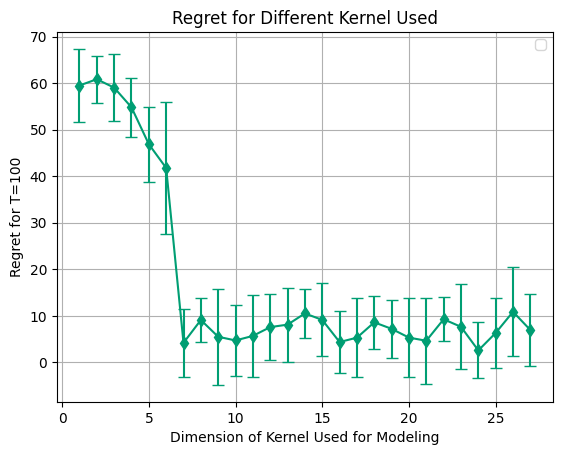

[np.float64(59.51485206642763), np.float64(60.86623129040502), np.float64(59.055581550990865), np.float64(54.823132332164384), np.float64(46.89975175801242), np.float64(41.78046397733143), np.float64(4.182726255099336), np.float64(9.096239244987284), np.float64(5.492487556020595), np.float64(4.699936722046666), np.float64(5.679215756099274), np.float64(7.569336910323977), np.float64(8.099647161403459), np.float64(10.511796483305785), np.float64(9.116334046624674), np.float64(4.358148583935054), np.float64(5.2979349854466955), np.float64(8.597383709378395), np.float64(7.194529713431206), np.float64(5.308515863653994), np.float64(4.636238488452516), np.float64(9.25714934919908), np.float64(7.629183709303018), np.float64(2.5560840075552806), np.float64(6.3142372447313315), np.float64(10.865939754370574), np.float64(6.94362150181482)]
[np.float64(7.866061036436186), np.float64(5.038149260217415), np.float64(7.247884100948871), np.float64(6.349682095713663), np.float64(8.038393120315263), n

In [ ]:
w_random = np.array([1 for _ in range(27)])
# w_random = np.random.normal(loc=0.0, scale=sigma_w, size=27)

qubits = 3
seed = 1
bounds = [(0, 2*np.pi), (0, 2*np.pi),(0, 2*np.pi)]

quantum_f = lambda X: np.array([f_draw_from_GP(X[i]) for i in range(X.shape[0])])


dim_tried = []
regret_for_dim = []
std_regret_for_dim = []

for dim in trange(1,28,1, desc="Dimension of Kernel Used"):

  kernell = lambda X,Y: reduced_matrix_classic(X,Y,dim=dim)

  gp = GaussianProcessRegressor(kernel=kernell, alpha=1e-4)

  avg_best, best_hist_all,std_regret = run_multiple_experiments_gp_ucb(
  f=quantum_f,
  gp=gp,
  bounds=bounds,
  n_runs=10,
  n_iter=100,
  init_points=1,
  n_grid=5,
  beta_func=None,  # use the default inside gp_ucb_nd
  random_state=42,
  error = 5/dim,#get_max_error(dim),
  verbose=False
)

  dim_tried.append(dim)
  regret_for_dim.append(avg_best[-1]/6) #5.2
  std_regret_for_dim.append(std_regret[-1]/6)
  print(avg_best)


plt.errorbar(dim_tried,regret_for_dim,std_regret_for_dim,ls="-",
             marker='d',
             color="#009E73",
             alpha=1.0,
             capsize=4)
plt.title("Regret for Different Kernel Used")
plt.xlabel("Dimension of Kernel Used for Modeling")
plt.ylabel("Regret for T=100")
plt.grid(True)
plt.legend()
plt.show()


print(regret_for_dim)
print(std_regret_for_dim)

Dimension of Kernel Used:   4%|▎         | 1/27 [05:59<2:35:51, 359.69s/it]

[  4.44400785   8.62436759  12.40604469  16.85879127  21.38239904
  25.72887456  30.3944569   34.38676914  38.56377779  42.5737296
  47.06335188  51.14067364  55.8844595   60.08006417  64.4034457
  68.98030452  72.74955469  78.01663334  82.10651435  87.19025932
  91.78560944  96.22979682 100.83541944 105.75688372 110.0519887
 113.33490637 118.04666076 122.88974994 127.54785567 131.77012147
 136.60798945 141.24206177 145.58392561 149.75073445 154.59447895
 157.79823642 162.25138131 165.03091444 167.97786747 172.54618538
 176.49586562 181.34533588 184.74308165 189.89254204 195.06029676
 199.25512991 204.48730498 208.69702036 212.75180133 217.39600395
 221.09037736 225.68255436 230.1143598  234.48101761 238.047578
 242.45332845 246.23366105 249.90109082 254.81270055 258.8349326
 263.41396123 268.04979262 272.15053058 275.14710333 279.78402343
 284.76773795 287.5398179  292.28100122 297.10018801 300.21026367
 304.8161822  309.56220317 314.0683063  318.82098455 324.43415928
 329.0823643  33


Dimension of Kernel Used:   7%|▋         | 2/27 [11:58<2:29:34, 358.97s/it]

[  3.86145593   7.6230134   10.22732267  14.41740732  18.27262311
  22.14520831  26.63452331  30.09668631  34.39023507  38.75674592
  43.13797173  47.48738207  52.21614302  56.84813854  61.53392515
  65.82951755  69.99910533  74.38811875  78.82060704  83.58757971
  87.61174649  92.14643206  94.71985453  98.59453299 101.7530731
 105.96816701 110.70027164 114.66757266 118.7748479  123.38174062
 127.73251834 131.73171144 135.34230201 140.23259863 144.25493574
 145.39482435 148.13212298 151.7722569  156.00466943 160.2343797
 164.52817488 168.52880695 172.22096368 175.027864   179.14839813
 183.73343608 187.98643799 192.70005725 197.09657474 201.69371555
 206.33837953 211.53316266 215.37488435 219.55741235 223.76694171
 228.83329836 232.9909361  237.5835945  241.95545052 244.35857301
 248.58612084 252.66805689 256.91565831 261.11633671 264.9586558
 269.38800699 272.86328861 276.62979837 280.77564154 283.83237701
 286.7200319  290.70542624 293.80824895 296.95432036 300.96080592
 306.49134404


Dimension of Kernel Used:  11%|█         | 3/27 [22:40<3:15:23, 488.49s/it]

[  3.83513337   7.54169978  12.05620344  14.60744264  18.82773015
  23.86122158  28.25607036  32.24706647  36.62320046  41.70392852
  46.25671736  50.61622912  55.1941755   59.75702125  64.53566683
  66.04211076  68.88221338  73.47024998  75.7322261   80.07378288
  82.88851316  86.43721698  87.4796974   92.17150855  96.64513316
 100.09550994 101.68166681 104.21785947 108.07196388 110.37944092
 114.69153829 118.02724994 121.76657087 126.49579113 130.38395484
 133.43058284 137.89247946 140.90343172 145.48209563 150.0190081
 154.39379251 157.44695145 161.90664795 165.8151885  170.02068869
 175.01027574 179.85842913 184.02597174 188.3925362  191.67307273
 196.52962962 201.13150393 203.56185854 207.40783906 212.00421361
 216.19069677 220.76226857 224.39664412 227.81002233 231.72792735
 233.83160041 235.89521595 239.58087797 240.25450445 244.64713958
 247.66052107 252.1425776  254.67447287 257.28865867 262.43360469
 264.76469909 268.15235463 271.39731679 275.22382232 279.57108269
 283.863282


Dimension of Kernel Used:  15%|█▍        | 4/27 [33:25<3:30:58, 550.36s/it]

[  4.56159413   8.65774655  12.82743071  17.62448099  21.67061652
  25.91287736  30.23799092  34.56927461  39.32013884  43.51096005
  47.54436975  50.75841288  55.33343444  59.7251694   62.7056329
  65.42201559  70.07301792  74.92588619  78.06033038  82.54772051
  86.75754295  90.84888788  94.49482276  98.51118215 102.37889189
 106.9803904  109.86494509 113.35431957 115.91727906 120.09244366
 124.15953945 127.9628946  131.261179   134.58052929 138.01434686
 141.54935268 144.65627482 149.12307395 153.2981085  156.51627168
 161.46274001 166.00019193 169.82394675 174.21036585 178.64605358
 180.16348164 185.0438481  188.87155257 193.37727196 197.9929177
 201.50893282 206.21751143 209.91764609 212.24694885 217.19954076
 221.44189156 225.9224182  230.75096725 235.21241448 239.59259131
 243.61300125 245.58198428 249.73413715 251.24614606 254.66194407
 256.38348094 257.44848088 260.87972882 265.52502876 268.63547809
 272.91331881 276.19702645 279.996534   284.36268314 288.17319997
 291.3448417


Dimension of Kernel Used:  19%|█▊        | 5/27 [48:24<4:07:52, 676.00s/it]

[  4.42778022   8.53497214  12.71210407  15.49669402  19.76736006
  22.96004225  24.96363344  28.33457585  30.38095272  32.73325159
  34.39384047  39.1448571   41.49519041  43.44026068  46.66506369
  49.29629424  53.12441724  55.615348    58.54555529  62.46275165
  64.67551808  68.5511894   70.99037277  75.2721695   80.05034288
  83.06097414  86.17900349  88.36500899  93.07745848  94.48337507
  97.36778905 100.37041346 103.29756327 107.13497635 111.73889293
 114.5032843  119.23821461 123.12766445 124.55074933 128.65590952
 133.31629685 135.99915915 139.48969195 140.95158536 142.79078391
 147.2702636  150.93854659 154.48481415 156.55755008 159.26111217
 161.73295429 166.4375035  168.72494111 172.70878775 176.61991212
 179.07494983 182.79373869 185.45105725 187.10541123 191.24832399
 195.40407301 199.29346328 201.63240372 204.21819169 207.56373821
 209.30193328 213.31355005 218.1777724  220.4349058  225.16907213
 229.69225333 232.32317022 236.4912322  239.59183479 243.85542608
 246.89610


Dimension of Kernel Used:  22%|██▏       | 6/27 [1:03:26<4:23:30, 752.89s/it]

[  2.83934836   6.03575987  10.49082414  14.7267761   18.2325258
  19.59221358  23.30139981  25.91795799  29.9827533   32.22419688
  35.41232428  37.86688568  42.53274675  44.16177072  46.33177009
  49.76276894  52.61649311  54.1730429   55.67159255  59.44423915
  63.04427789  64.75378191  69.39792225  72.69133931  74.0288624
  77.86981524  81.95466305  84.12949381  86.97733054  89.80703426
  92.56496016  96.50013786  98.64928776  99.25082892 101.4973321
 106.1671474  107.67714453 108.25885004 111.20439839 113.32999516
 115.6918847  118.72105966 123.22063967 128.2961484  132.70244748
 136.32056591 138.71042821 141.28118998 143.63894572 145.61048125
 149.82929193 152.48001676 156.01696955 159.91949323 162.27378129
 163.32134464 166.99637117 169.90134462 173.67283947 176.97957867
 179.85462734 180.81238172 182.20277417 183.43879314 186.36732318
 189.42984291 192.65789672 195.85164303 199.58009736 200.37383798
 201.67212181 204.09075885 208.99277927 211.58506885 213.69532303
 216.23366229


Dimension of Kernel Used:  26%|██▌       | 7/27 [1:22:48<4:55:27, 886.38s/it]

[ 4.60696117  8.17523964 12.66497988 16.4108582  19.6291064  23.47587333
 25.84810173 28.92820072 31.26011885 32.11367295 33.27809152 34.6124643
 35.75519299 37.22933652 37.91571337 38.53507516 39.79717782 41.03229339
 42.58702143 43.54000318 44.6471422  45.44632346 46.2578352  47.60193093
 48.41561006 48.86911679 49.70477369 50.51721674 51.03426256 51.99944936
 52.84482075 53.32418813 53.82664361 54.43285424 55.17794393 55.69337951
 56.1168604  57.13849167 57.48977473 58.04243643 58.77953312 59.02239254
 59.12283859 59.76234115 60.03734827 60.45924244 60.65335106 60.84283186
 61.04070815 61.50541079 61.53103415 61.57957888 62.08902207 62.18950943
 62.16042478 62.26691224 62.2937492  62.48063554 62.61297964 62.59168025
 62.62384939 62.89114528 62.9848161  63.03441678 63.09166267 63.18624865
 63.4824131  63.54111035 63.60060532 63.64022638 63.64114127 63.77003687
 63.91866416 64.08142711 64.10540386 64.43376242 64.51078228 64.59234554
 64.70290727 64.81398716 64.88545851 64.92037503 64.


Dimension of Kernel Used:  30%|██▉       | 8/27 [1:42:06<5:08:06, 972.99s/it]

[ 3.43208831  6.23475708 10.37489353 14.58421734 19.12374415 19.88633547
 21.99112102 22.35349688 22.63152178 23.09503975 23.23404087 23.52586601
 23.74035115 24.31412155 24.63625042 25.03166807 25.10870407 25.54882199
 25.70944574 25.96684612 26.13853514 26.39203082 26.77797817 26.96294362
 27.60049057 28.00596368 28.39986256 28.43543187 28.86326902 29.02216742
 29.32023215 29.34407343 29.48269483 29.8556942  29.96104541 30.04531649
 30.15272844 30.30882966 30.7955443  30.97175533 31.3099409  31.5136383
 31.56185715 31.47214196 31.54971846 31.91106875 32.0294411  32.17747183
 32.23030806 32.33402698 32.37518562 32.4811082  32.69086871 32.99041689
 33.27667641 33.52166902 33.7221733  34.17193539 34.41732018 34.44943087
 34.40471084 34.32231617 34.45442574 34.60096908 34.5939189  34.5706222
 34.39025336 34.53085728 34.53884269 34.72623275 34.93670518 35.01315915
 35.08285613 35.14934202 35.29913209 35.3252427  35.19745676 35.31848391
 35.57263983 35.7470667  36.03637391 36.23849699 36.2


Dimension of Kernel Used:  33%|███▎      | 9/27 [2:06:21<5:37:03, 1123.50s/it]

[ 4.46882229  8.83684376 12.29848877 16.16143491 20.43728515 22.68511146
 25.04825867 28.43740077 29.55928814 31.23097604 31.33195495 31.77847304
 32.34539321 32.79589656 32.91019771 33.25869805 33.34790528 33.70062157
 33.94539394 34.17025113 34.26166156 34.47236175 34.87662178 35.10110109
 35.37983281 35.69122025 36.08621254 36.23749927 36.63299706 36.84597422
 37.04780511 37.04568651 37.35198752 37.41376987 37.63931809 38.39012055
 38.48477999 38.6779901  38.65879761 38.76799861 38.83947063 39.19144483
 39.09732125 39.34010134 39.46995952 39.62876915 39.68343492 39.87276716
 40.14644233 40.34490204 40.56753953 40.7158009  40.75537311 40.97819167
 41.24204694 41.62265405 41.77652244 42.41674487 42.56078276 42.60533451
 42.65214837 42.8708003  43.08062879 43.1250243  43.42279122 43.42885342
 43.51445796 43.57964124 43.63563679 43.55183909 43.73094775 43.75676678
 44.03444212 43.92460012 43.87045647 44.1008666  44.18458103 44.22350547
 44.33072992 44.44911466 44.8257941  45.0046453  45


Dimension of Kernel Used:  37%|███▋      | 10/27 [2:30:44<5:48:03, 1228.44s/it]

[ 3.96834096  8.1828332  12.47251946 15.86231391 19.81462629 23.75068499
 28.67524014 32.92214423 36.49652252 37.68150454 39.30617251 40.55855053
 42.35622708 44.35155007 45.77265098 46.93834256 48.09602506 49.35043772
 50.78460637 51.51092952 52.39786664 53.04851819 53.8418437  54.33465668
 54.9507474  55.6908627  55.89997229 56.47495159 56.70709082 57.41042521
 57.66985807 57.93731312 57.92099541 58.59223789 58.74695953 59.00054261
 59.22017122 59.78675201 60.11971863 60.25890583 60.32576575 60.73057521
 60.9409797  60.93074738 61.31337621 61.61380213 61.71034009 61.99664042
 61.97507871 61.93118634 62.56716771 62.74741851 62.61943965 63.00948175
 63.09189292 63.1370302  63.23432165 63.44256925 63.51821945 63.50651069
 63.66113906 63.74940248 63.89367605 64.14482743 64.38578047 64.60667595
 64.77407964 64.84148842 64.9429938  64.95628618 65.25746941 65.40886321
 65.34034649 65.55221814 65.4705386  65.60205761 65.70341137 65.99502515
 66.10112728 66.31334356 66.47936713 66.49668567 66


Dimension of Kernel Used:  41%|████      | 11/27 [2:59:37<6:08:46, 1382.93s/it]

[ 4.31540694  9.05138911 13.29368418 17.21053832 21.78906372 26.29632083
 28.55435027 31.79942894 33.91048693 36.41965687 38.14548594 40.69815343
 41.0465647  41.4892744  41.84382867 42.84307113 43.47653296 43.69218183
 43.99152832 44.70210048 45.38177053 46.01919964 46.68128824 47.59806903
 48.05953301 48.30456666 49.16667567 49.90511437 50.41467194 51.30824022
 51.75120345 52.5446694  53.1266714  53.58133042 54.14176843 54.2622209
 54.65889914 54.79324152 54.75150252 54.73190918 54.73014693 54.78134744
 54.7810326  54.84849221 54.93245225 55.04015737 54.97210059 55.15642128
 55.01562011 54.91690268 54.79762824 54.8109992  54.63223131 54.85993458
 54.79756136 54.78714469 54.73564153 54.58281284 54.51285646 54.48043779
 54.48194228 54.46861172 54.37301972 54.31289526 54.32016128 54.26754919
 54.11665647 53.91414422 54.00089295 53.95282407 53.8038106  53.74619299
 53.90410563 53.80785005 53.84791725 53.93489347 53.96945924 53.9038595
 53.83407569 53.96421744 53.7804197  53.82206619 53.7


Dimension of Kernel Used:  44%|████▍     | 12/27 [3:28:31<6:12:24, 1489.62s/it]

[ 3.9823721   6.63283231 10.68216282 14.11101308 17.98450176 22.97051992
 24.50076399 25.76192337 28.59511359 32.2327593  37.25964458 41.80730986
 42.03380689 42.5024357  42.7363869  43.3864968  43.65096319 44.08417379
 44.50647479 44.71382185 45.07952905 45.94194913 46.41139602 46.57761003
 47.11882136 47.20444111 47.73529372 47.97977769 48.32638593 48.42178043
 48.84881    49.28847453 49.34467008 49.64205419 49.98012329 50.22147581
 50.25974325 50.22200874 50.63299854 50.96000765 51.07142092 51.47989791
 51.71204244 51.86547509 52.12937045 52.28755076 52.40931909 52.44079035
 52.91184579 53.15574826 53.33836348 53.56284706 53.95243504 54.14315383
 54.4255299  54.62829475 55.0081032  55.25580568 55.40370404 55.78977428
 55.94301551 56.0457474  56.09188866 56.2135358  56.42551929 56.41397666
 56.604734   56.70823068 56.9735588  57.05922204 57.28906404 57.65273066
 57.61257381 57.70010563 57.8201246  57.8316445  58.05907769 58.0080331
 58.22298373 58.31887043 58.4759677  58.34597346 58.


Dimension of Kernel Used:  48%|████▊     | 13/27 [4:01:57<6:24:04, 1646.03s/it]

[ 4.15488936  8.65876069 12.67514029 16.22110595 21.39459756 24.54022515
 28.67916116 32.3931243  37.11311727 41.02694935 41.91582258 45.05238541
 45.68747968 45.99962066 46.42744226 47.35457828 47.57033703 47.93473611
 48.09174396 48.35407337 48.74837323 49.0935792  49.15821734 49.46325794
 49.6528324  49.97596566 50.07551943 50.35814748 50.60533829 50.94853903
 51.07120257 51.30578563 51.68494524 51.69328957 52.17164818 52.24012133
 52.22226876 52.15182124 52.22426662 52.53011824 52.89142336 53.11407696
 53.17920471 53.19489323 53.30520432 53.37859689 53.64479614 53.94091863
 54.04839311 54.14998358 54.21848194 54.2951318  54.44180495 54.52140907
 54.88514883 54.84642733 54.89555815 55.06463192 55.11903988 55.23398347
 55.4470187  55.61251634 55.7707462  55.72769953 55.86146254 56.03682059
 56.03960626 56.10068201 56.06639268 56.07432799 56.27763191 56.67078636
 57.07483197 57.12023682 57.33215552 57.23503707 57.24973437 57.41007377
 57.54538086 57.55374007 57.46957852 57.60664287 57


Dimension of Kernel Used:  52%|█████▏    | 14/27 [4:35:18<6:19:51, 1753.19s/it]

[ 3.83639675  8.82400861 13.51795445 18.65138719 21.68770517 26.13978176
 28.69233428 31.00404093 32.96838345 35.27732313 37.676399   38.67215304
 39.63772026 41.16164161 42.0052494  42.43255377 42.49550834 42.95779437
 43.48730206 43.9409652  44.39677561 44.87677223 45.47076509 45.53321389
 45.57164735 45.84419707 46.09369778 46.07529876 46.27416089 46.76055437
 46.92382527 47.1301047  47.64816187 47.8317356  48.10665413 48.30240607
 48.37958445 48.38962228 48.49250987 48.72588437 48.94722247 49.074088
 49.32266953 49.2703081  49.34756704 49.71541128 49.82392266 50.18171901
 50.33397187 50.46710497 50.78397663 50.84422371 50.89592939 51.0615871
 51.00085006 51.20100549 51.56955816 51.78103596 51.77969702 51.93270053
 51.96044479 51.93154162 52.01179685 52.0731854  52.06366429 52.1062118
 52.13916151 52.46020295 52.41795982 52.4953474  52.64518229 52.79377207
 52.83503859 53.06287927 53.00912316 53.19479759 53.18442098 53.27677012
 53.3994372  53.50739089 53.47741278 53.56586309 53.698


Dimension of Kernel Used:  56%|█████▌    | 15/27 [5:12:59<6:21:17, 1906.45s/it]

[ 4.02890356  8.55809125 12.95872172 17.24883585 22.23396111 23.89606392
 27.00053136 30.8716476  31.04535469 32.39222238 34.20155584 35.16484411
 36.51754627 39.0998013  41.87905428 43.96788699 43.94414209 44.11350283
 44.10049549 44.04852733 44.31077273 44.35771256 44.38379002 44.45860132
 44.47445671 44.6925571  45.05135738 45.14941575 45.45825228 45.50070233
 45.69274311 45.69762193 45.72494464 45.68862127 45.64106032 46.05989299
 46.05813041 46.1255596  46.23246342 46.12140272 46.21470744 46.2253403
 46.35600908 46.69289513 46.65867007 46.8369642  47.22671638 47.24460482
 47.33439435 47.36944489 47.46369806 47.4800178  47.65753404 47.77709196
 48.03346307 48.20376495 48.37477884 48.56195685 48.85202518 48.86244985
 48.80083134 48.84114295 49.08705778 49.04057074 49.01084705 49.01036607
 49.13639535 49.26339892 49.30422311 49.59724156 49.59776279 49.64312201
 49.74764653 49.67902416 49.79033804 50.15715408 50.16285662 50.19638827
 50.24182588 50.43539934 50.42114018 50.51961356 50.


Dimension of Kernel Used:  59%|█████▉    | 16/27 [5:50:35<6:08:46, 2011.51s/it]

[ 2.65018275  4.99963894  7.28300417 10.19602571 12.25869709 15.22295726
 18.13825414 20.4149094  25.09123285 27.67784244 28.82807227 29.98122388
 31.98494323 32.22673219 32.54950141 32.73322817 36.59188546 37.06397326
 37.16121734 37.47377826 37.65605067 37.98661823 38.26298727 38.53175499
 38.84440359 38.96629773 39.35548851 39.47272787 39.70129567 39.6760291
 39.8445331  40.22014083 40.55763959 41.00517339 41.13809384 41.49159086
 43.64619972 43.8072391  44.00891569 44.09820118 44.27489951 44.35838778
 44.44382722 44.50696609 44.71735301 44.73822545 44.86642761 45.00358914
 45.12745594 45.15718618 45.1760346  45.2215409  45.6318707  45.82984827
 45.87565253 45.84990043 46.16338167 46.23989184 46.25968567 46.41278546
 46.40295214 46.47430846 46.54632554 46.58082843 46.55593016 46.5808294
 46.74037687 46.80417878 46.95489227 46.96604208 47.15815164 47.1539602
 47.45553851 47.61380186 47.64176912 47.72643012 48.17554238 48.34812658
 48.46118773 48.56022909 48.63984378 49.03827608 49.07


Dimension of Kernel Used:  63%|██████▎   | 17/27 [6:32:41<6:01:03, 2166.37s/it]

[ 1.76207626  4.67999742  7.58155313  9.78986221 12.81798329 16.63084358
 18.61855212 21.52440914 22.517004   24.92315537 26.19237458 28.06280034
 30.55315914 30.63100818 30.58554799 34.2722715  39.06045007 39.85853955
 39.86329459 39.96061223 40.11445764 40.17927781 42.86329005 42.95456907
 43.14264294 43.18792148 43.17355755 43.28527281 45.29438015 45.30555184
 45.29417957 45.38183221 45.43097689 45.43819175 45.59613345 45.64548783
 45.98490382 46.09532836 46.47151621 46.45937962 46.62203408 46.59823598
 46.57389961 46.5950593  46.52891842 46.77600656 47.03355011 47.02298471
 47.17055227 47.33644297 47.31725242 47.41978595 47.57287565 47.630677
 47.69406085 47.75513725 47.83466981 48.05511598 48.11359525 48.03962629
 48.13613352 48.06625855 48.20590157 48.17781369 48.22195514 48.21642427
 48.28607607 48.2581544  48.27754902 48.32601548 48.27524224 48.3354941
 48.33073665 48.35314346 48.4005893  48.30276597 48.35013506 48.56870205
 48.61905452 48.64332165 48.92113211 48.95639486 49.03


Dimension of Kernel Used:  67%|██████▋   | 18/27 [7:15:28<5:43:00, 2286.72s/it]

[ 4.40186957  8.48418517 13.09866514 15.40377267 17.78573339 20.05191424
 22.41613943 24.83853576 25.45551232 27.35130504 30.06165947 32.25560705
 33.1605982  37.53224738 37.87582833 38.19754896 38.35383628 40.85607643
 43.33356392 43.40371798 43.50489899 43.54181826 44.08230428 44.17880913
 44.45391428 46.94629842 46.98121885 47.1108417  47.14980288 47.22028085
 47.3874948  47.39366177 47.55327936 47.6629914  47.8392201  47.82233407
 48.01192477 48.17249004 48.14463652 48.12258136 48.31209531 48.36525279
 48.39272883 48.73170357 48.82376966 49.00615168 49.0842711  49.20821789
 49.25785285 49.27231057 49.38027534 49.35486763 49.85358585 49.86635647
 49.89660374 50.09118154 50.20075489 50.50154915 50.64104419 50.84245541
 50.98754978 51.02856494 51.23738165 51.43678211 51.72027469 51.92339407
 52.110957   52.30942933 52.4830509  52.54802769 52.63205916 52.62973648
 52.76661418 52.8692814  53.16154321 53.25388475 53.38509966 53.4636275
 53.45587626 53.49979561 53.5839484  53.96388289 54.


Dimension of Kernel Used:  70%|███████   | 19/27 [8:02:15<5:25:43, 2442.92s/it]

[ 2.97186306  7.68322144 12.09460712 15.01080245 16.94096839 19.23898379
 22.02582345 23.84028131 26.73416045 30.15491887 30.43937099 30.88216174
 33.09394141 35.57777461 35.85091925 35.85889857 37.98084796 42.56073666
 44.54842803 44.80300699 44.9011868  44.92411929 47.23241655 47.35065292
 49.65527753 51.53735908 53.56620724 53.50264133 53.56227719 53.57377157
 53.7375104  53.88397482 54.12138668 54.1465144  54.10845866 54.11848544
 54.14618338 54.36801632 54.34070773 54.37141079 54.38666517 54.4458183
 54.4607053  54.66461767 54.75887842 54.87649803 54.90530299 54.90142261
 54.92128691 54.83117903 54.97490533 55.06891953 55.25596124 55.20755687
 55.18166549 55.10040748 55.21690515 55.49181415 55.5924114  55.60010921
 55.76357891 55.72970613 55.92754362 56.01309213 56.02260838 55.97160058
 56.05425157 55.9706581  56.0223425  56.02693113 55.93406338 55.93368543
 55.95244614 56.04385209 56.31970294 56.38240565 56.33072941 56.44149753
 56.56047806 56.93009121 57.04168531 57.01138349 57.


Dimension of Kernel Used:  74%|███████▍  | 20/27 [8:49:00<4:57:41, 2551.68s/it]

[ 3.65503951  7.21108189  9.7250761  11.98523191 12.17735009 14.44209066
 15.72352299 16.74185714 17.33762729 17.5321063  21.73143912 21.61010036
 21.51450726 21.77652398 21.56506809 21.37609173 21.19752946 23.17321991
 23.05246857 22.82871065 22.60624558 22.54952831 23.18588538 25.14707351
 26.85290256 26.789642   26.56905323 26.27906668 26.04296946 25.91344111
 25.68580773 25.72389868 25.52006186 25.30709562 25.01408814 24.94973505
 24.9247106  24.76685452 24.56815905 24.30102296 24.01481656 23.99817028
 23.82907949 25.5947547  25.39633775 25.1800517  25.12998682 24.92908405
 24.67699349 24.58150382 24.41559015 24.34029449 24.24985738 24.10533804
 23.82534386 26.34260038 26.16274433 26.01854666 26.00746293 25.76652575
 25.61852494 25.37143596 25.41078455 25.15075799 24.91980038 24.92835209
 24.67061728 24.49527041 24.28686964 24.04592156 23.75598879 23.75381272
 23.47441147 23.25474813 23.05796564 22.81913215 22.73877797 22.44954089
 22.31622354 22.02659235 21.91986268 21.65188152 21


Dimension of Kernel Used:  78%|███████▊  | 21/27 [9:40:41<4:31:38, 2716.50s/it]

[ 4.95703519  9.3367374  13.35791722 17.88568419 21.91120207 26.29525696
 27.23626998 29.70772941 32.94031629 35.3365087  35.54344808 36.10532544
 36.35809042 38.74431351 39.10237099 39.34564394 41.5947183  42.29820387
 42.55443154 42.65377864 44.81644825 45.57760821 47.70457282 47.8100742
 50.03831721 52.65272051 54.79074934 54.91894147 54.96065515 55.08836663
 55.32527751 55.59353783 55.59782125 55.68849207 55.89161446 55.96171603
 56.06066206 56.21225179 56.39685793 56.60890658 56.86631907 57.21148843
 57.4254824  57.64446399 57.76063496 58.01484771 60.47738566 60.72255057
 60.82524482 61.05355409 61.16517813 61.42348618 61.67563012 61.94810087
 62.26148146 62.43024036 62.60533806 62.64659015 62.84677903 63.26980375
 63.46482303 63.57378928 63.77787509 63.91079026 66.19084814 66.55863729
 66.68897775 66.78950773 66.85783078 67.07849695 67.1848936  67.24156819
 67.46382731 67.6282746  67.739042   67.85322955 68.04005853 68.13429674
 68.3249654  68.38632202 68.53502428 68.63180662 68.


Dimension of Kernel Used:  81%|████████▏ | 22/27 [10:32:47<3:56:37, 2839.48s/it]

[ 4.28375433  7.43548999  9.61342577 11.90412092 14.67727646 16.88149226
 20.07551128 21.87311458 23.90435318 23.88035859 25.6866615  26.57141705
 28.7903275  28.75793233 30.67226425 35.04024104 37.17266146 39.07044936
 41.3766246  43.70368043 43.76378393 43.72344693 46.50288032 46.55307714
 48.57219793 48.7540467  48.96862226 51.34442855 51.23318473 51.25577921
 51.63652533 51.66439869 51.73732462 51.81514136 51.84160146 51.82997798
 51.86452569 54.06838298 54.16597332 54.36947213 54.40443224 54.37829354
 54.38113326 54.50528385 54.61000192 54.51331995 54.52556734 54.67518669
 54.73190198 54.72413914 54.8058291  54.73830718 54.66467754 54.72958952
 54.66224749 54.65281492 54.71958004 54.71137901 54.68751708 54.67171872
 54.62311163 54.59995464 54.53243529 54.73761033 54.6860564  54.70197865
 54.7105885  54.77345198 54.72937997 54.83700883 54.89856923 55.02242144
 54.96629454 55.05322278 55.04433443 55.0982479  55.22325609 55.17602927
 55.31264754 55.27868125 55.30837676 55.25722708 55


Dimension of Kernel Used:  85%|████████▌ | 23/27 [11:30:05<3:21:15, 3018.99s/it]

[ 3.88088879  6.73143835 10.23755848 14.70896759 17.06101015 19.93742229
 23.07316398 26.44471694 29.06635855 31.32422655 33.51513415 35.83402937
 40.40229419 42.3938403  42.68075138 43.56697062 43.9529061  46.12820041
 49.50765724 51.81429195 54.11663447 56.35856591 56.40650278 56.47255012
 56.5084825  56.59483594 56.49424237 58.67478411 58.71368056 60.98417055
 61.08574975 61.10743532 61.15775868 61.44496694 63.93851366 64.11368803
 64.15923139 64.35388258 64.45400289 64.43196694 64.69594154 64.6573156
 64.76213113 66.93572517 66.92943902 66.97136584 67.01103844 67.32405462
 67.56034103 67.58547511 67.65847241 67.60959479 67.76278572 67.98430736
 68.06438625 68.04127527 68.11982066 68.15427587 68.22174134 68.17765306
 68.21418236 68.29514173 68.40785552 68.37092    68.48042749 68.52287357
 68.61071694 68.64243594 68.6129992  68.8229773  68.93232002 69.15686722
 69.22876632 69.35444452 69.46741185 69.49986246 69.45244379 69.40162038
 69.56257692 69.52515484 69.6667546  69.73934597 69.


Dimension of Kernel Used:  89%|████████▉ | 24/27 [12:27:21<2:37:12, 3144.13s/it]

[ 3.6937147   8.24961135 10.91353017 12.54701843 13.50719957 15.76970177
 16.29992835 17.18279392 18.03417232 18.89741059 20.84141079 23.49798581
 25.84822542 28.00500402 29.88812533 32.12828543 34.69399669 36.84046492
 38.93947773 39.11397314 43.51924249 45.60198271 45.72442888 45.81485609
 45.9733898  46.12012278 48.90194389 49.00830541 49.24793083 49.25557176
 51.59903014 51.77100875 51.92812475 51.95590794 51.96278354 54.42069872
 56.84523306 56.8821867  56.91042394 57.16514906 57.23556335 57.1766739
 57.11263196 57.17777087 57.41677699 57.45672972 57.7194101  57.91148064
 57.86279455 58.05038614 58.13799983 58.11695191 58.15269652 58.31898739
 58.4216412  58.38799732 58.49264051 58.53113264 58.59591379 58.69586624
 58.67864715 61.11279718 61.17698171 61.17358883 61.12037037 61.15206087
 61.19945522 61.17757953 61.21547228 61.23510856 61.21949255 61.30073134
 61.35008934 61.38313447 61.39134343 61.4304868  61.39446501 61.33897794
 61.38827692 63.46964397 63.52660216 63.58030761 63.


Dimension of Kernel Used:  93%|█████████▎| 25/27 [13:29:38<1:50:44, 3322.04s/it]

[ 4.98508849  8.5871838  12.01918798 14.45233958 17.86237854 20.52843486
 21.55051327 22.45872796 23.10366764 23.63926355 24.76624009 27.10131553
 29.2169462  29.396294   31.57070767 33.83813994 38.02046386 40.15771437
 40.22053573 40.07824133 42.08248489 41.95315232 43.98928667 46.1167053
 46.17603312 46.01640203 48.1590149  48.17852859 48.16928652 50.72079698
 52.98839373 54.89677241 54.74764946 54.81887444 54.77146354 56.81146585
 56.68969875 56.47086147 56.61679088 56.71364831 56.56364532 56.44708535
 56.27301888 56.21585273 56.09864258 55.96494411 56.02975469 55.95934148
 55.86946792 55.79014594 55.71984436 55.8488402  55.80543906 58.14485231
 58.04754745 57.98065253 57.89420627 57.88394065 57.86278794 57.78149719
 57.75519139 57.69179815 57.62404837 57.48099867 57.49156818 57.58592834
 57.52079561 57.44082502 57.3840504  57.26315577 57.21686996 57.13102078
 57.07964335 57.03462753 56.87911485 56.74859873 56.7735522  56.56613879
 56.63542309 56.58307555 56.72652066 56.65109361 56.


Dimension of Kernel Used:  96%|█████████▋| 26/27 [14:31:37<57:21, 3441.12s/it]  

[ 4.50089721  8.97463949 13.61537354 18.28798333 22.88295314 27.25483935
 27.37290516 28.75513642 29.51489517 31.02587406 32.56956867 33.09963439
 33.87486633 33.97785641 33.95108629 34.01095639 38.33053902 42.91902554
 47.61386211 47.60307513 49.43505648 49.43697722 49.40543518 54.03805628
 53.97089275 56.31192924 56.34271726 58.36600288 58.31107282 58.32012307
 58.2449226  58.2119756  62.864161   63.05164652 63.03355873 63.05004859
 65.12495063 65.12891424 65.20879788 65.27572307 67.21305474 67.2532227
 67.40426322 67.41775239 67.72773238 67.76838207 67.80980676 67.9888551
 68.08131627 68.20591232 68.48004297 68.56920824 68.56374778 68.67702988
 68.7682062  68.85635775 68.85176194 70.78731106 70.75955219 70.97391759
 71.20072857 71.14474124 71.2123054  71.34343341 71.35370662 71.28874203
 71.35473595 71.47028242 71.49710183 71.52727377 71.59415254 71.5491412
 71.54197733 71.67461161 71.81828297 71.85033624 72.0063473  72.06156292
 72.0377855  72.11898174 72.30388626 72.58323523 72.64


Dimension of Kernel Used: 100%|██████████| 27/27 [15:38:18<00:00, 2085.14s/it]
<ipython-input-10-ed9157f89696>:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


[ 3.31895439  6.72922982 11.25504334 14.97090292 15.66963675 16.696936
 18.28720917 20.03840243 20.46374549 22.43648308 22.93258607 24.07254638
 23.94486604 26.16181698 28.69442712 31.07188712 31.3840134  31.40246673
 33.47265189 37.65419932 40.21978194 42.4472     44.41696621 49.01308254
 48.96340607 51.06391706 53.01874324 55.2161205  55.44749729 55.52058313
 55.83855811 58.19568239 58.14658077 58.25357264 60.82038788 60.82448906
 60.72727145 60.743087   60.70502388 60.89338643 60.99607037 63.40845258
 63.31526724 63.35421826 63.37494217 63.51609686 63.55415417 63.62539485
 63.59655258 63.67870786 63.6625136  63.68013249 63.54293941 63.45471453
 63.59740861 63.55235879 63.50851842 63.44615285 63.47895656 63.46985178
 63.55529791 63.53831221 66.25551361 66.10589845 66.11916815 66.25882203
 68.38068913 68.45160578 68.50847504 68.51629625 68.51886854 68.56184586
 68.47877789 68.7028432  68.81154496 68.92050002 68.84598461 69.00181494
 68.98020086 68.84801115 68.76893773 68.99052818 68.9

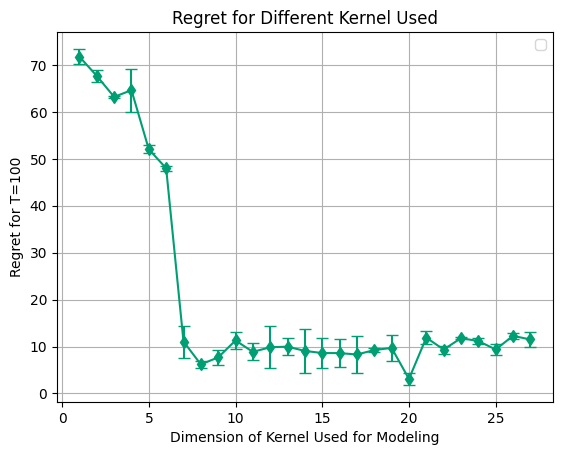

[np.float64(71.78014929167705), np.float64(67.68346377039035), np.float64(63.2125244984249), np.float64(64.6451118769083), np.float64(52.03414263981895), np.float64(47.997470089679524), np.float64(11.058717979082461), np.float64(6.184149779061599), np.float64(7.681799872406351), np.float64(11.292093545565166), np.float64(8.84572347725634), np.float64(9.848617414946608), np.float64(9.962718919948438), np.float64(9.060694670712927), np.float64(8.601820538688061), np.float64(8.592806125011279), np.float64(8.295564979396119), np.float64(9.243929224404969), np.float64(9.7025081721847), np.float64(3.0860564332269362), np.float64(11.88640334252275), np.float64(9.354040145104815), np.float64(11.77097415674001), np.float64(11.168934443654317), np.float64(9.365985273764842), np.float64(12.26800064883851), np.float64(11.496462605309807)]
[np.float64(1.6593472723335811), np.float64(1.2492464071420954), np.float64(0.24907866842408544), np.float64(4.582572181508657), np.float64(0.8510187134956482), 

In [ ]:
w_random = np.array([1 for _ in range(27)])
# w_random = np.random.normal(loc=0.0, scale=sigma_w, size=27)

qubits = 3
seed = 1
bounds = [(0, 2*np.pi), (0, 2*np.pi),(0, 2*np.pi)]

quantum_f = lambda X: np.array([f_draw_from_GP(X[i]) for i in range(X.shape[0])])


dim_tried = []
regret_for_dim = []
std_regret_for_dim = []

for dim in trange(1,28,1, desc="Dimension of Kernel Used"):

  kernell = lambda X,Y: reduced_matrix_classic(X,Y,dim=dim)

  gp = GaussianProcessRegressor(kernel=kernell, alpha=1e-4)

  avg_best, best_hist_all,std_regret = run_multiple_experiments_gp_ucb(
  f=quantum_f,
  gp=gp,
  bounds=bounds,
  n_runs=2,
  n_iter=100,
  init_points=1,
  n_grid=10,
  beta_func=None,  # use the default inside gp_ucb_nd
  random_state=42,
  error = 5/dim,#get_max_error(dim),
  verbose=False
)

  dim_tried.append(dim)
  regret_for_dim.append(avg_best[-1]/6) #5.2
  std_regret_for_dim.append(std_regret[-1]/6)
  print(avg_best)


plt.errorbar(dim_tried,regret_for_dim,std_regret_for_dim,ls="-",
             marker='d',
             color="#009E73",
             alpha=1.0,
             capsize=4)
plt.title("Regret for Different Kernel Used")
plt.xlabel("Dimension of Kernel Used for Modeling")
plt.ylabel("Regret for T=100")
plt.grid(True)
plt.legend()
plt.show()


print(regret_for_dim)
print(std_regret_for_dim)

Dimension of Kernel Used:   4%|▎         | 1/27 [00:36<15:39, 36.14s/it]

[  3.72908783   7.20494799   9.61981448  12.4460523   16.69454653
  20.68175883  23.49616096  27.26381516  30.09158049  32.30264614
  36.01859501  39.31496852  42.93713334  46.57568328  50.00792126
  54.04009026  57.95034542  61.36169579  64.36093973  68.36719901
  71.81076671  75.86796143  78.83895809  82.47109289  85.23265748
  88.19720283  92.18837244  95.46170562  99.54810925 103.5004602
 107.52864688 111.37503734 115.61147037 119.15904175 123.42412323
 126.48869261 130.2282352  132.8718001  136.32553282 140.31712739
 144.49578871 148.55703855 151.44073454 155.38691893 158.73757388
 162.09774897 165.40864606 169.27777353 173.35992696 176.96454895
 180.44684235 183.6100211  186.73404568 190.51924471 195.00953027
 197.53336864 201.05203146 204.30752539 207.3462936  211.18669126
 214.53146814 218.18946691 222.31712071 226.26344863 230.13634668
 234.24343268 237.93212855 241.94738165 244.90017123 247.54748945
 251.33473718 254.75353348 258.94814273 262.9551385  266.88671661
 270.647927


Dimension of Kernel Used:   7%|▋         | 2/27 [00:59<11:55, 28.61s/it]

[  2.49079785   6.46232557  10.44343218  14.78346748  18.57245024
  21.46782848  25.70963611  29.54694225  31.98524663  35.39799093
  37.24844742  41.04355652  44.95490362  48.85778181  52.76225619
  56.8189579   61.77341971  65.98026819  69.75368681  73.09800169
  77.09507614  81.01459906  83.77113369  86.94538821  90.57769796
  94.78597247  99.29692489 103.5151667  106.51939761 110.60753204
 114.53441882 119.01331946 122.90109211 126.84234196 130.89348642
 134.5560577  137.67501953 141.07976015 145.18065921 149.3416775
 153.10169046 156.84569007 160.68565737 163.69126696 167.24224007
 171.12457596 174.60271001 178.25254797 181.59257028 185.01393014
 189.52132623 193.18603129 197.10657226 200.64355213 202.76152797
 206.43342844 210.64656567 213.32559363 217.31938961 220.7621006
 224.42443926 227.86139482 231.4641137  235.16633837 238.81231677
 242.60906863 245.98661338 249.83744849 252.37076246 256.4017168
 259.20016813 263.44051999 266.60167317 270.71770573 274.40709637
 278.37073684


Dimension of Kernel Used:  11%|█         | 3/27 [01:35<12:47, 31.97s/it]

[  4.11114421   8.31993145  12.29986738  16.47782278  20.78453297
  24.80080896  27.64112788  31.26452269  35.45418908  39.86214046
  44.12544753  47.81260478  51.73948652  54.39710067  58.57217844
  62.14461022  66.3055813   70.52236794  74.41272703  78.35108547
  83.09110342  86.92778512  91.37774644  94.34120847  98.65533811
 102.36806827 106.39131933 110.54232772 114.69813955 118.97626911
 122.6272161  125.69938476 129.07607611 133.05843333 136.68075755
 139.65856801 143.83373011 147.22305604 151.32460964 155.58993477
 159.23794479 162.79574973 166.86307215 171.15971712 175.38730819
 179.45575491 182.82317736 186.67327257 190.70533953 194.41750979
 198.2583736  200.48960874 204.30824724 208.41249125 211.08059376
 214.92112944 218.53963939 221.09272568 223.9710397  227.80334764
 231.47016236 235.53821519 239.57856843 243.4166675  246.41743087
 249.95747773 253.66507134 256.82309502 260.91861353 263.53922149
 267.8932841  270.98911743 273.92609562 276.44679175 279.16108833
 283.63101


Dimension of Kernel Used:  15%|█▍        | 4/27 [02:12<13:05, 34.16s/it]

[  3.55674368   6.41891801   9.53766633  12.05285804  14.55507536
  16.99723092  19.37568485  21.35128571  24.94712553  28.07925878
  30.9626743   34.69778677  37.93114029  40.87961123  44.04609757
  47.38728925  49.99530784  53.46483797  56.79833133  59.67845521
  62.64657414  66.39284429  69.08379355  72.89987993  77.26497836
  80.78639824  82.99762705  86.13853505  89.7744198   93.29909243
  97.04844023  99.30024574 102.27154469 105.29706215 108.42924179
 112.22391237 115.13496321 118.0242984  121.62310373 125.08753678
 128.87976039 131.17256814 134.41296082 137.97630283 141.45762901
 144.59563093 146.8870791  149.8917183  153.79130484 155.6721486
 157.40057546 158.72142207 162.4394699  166.36008905 169.85631219
 172.08351148 175.68295843 178.40401495 181.37345838 185.48658487
 189.42685546 192.01772737 194.17071029 197.49323826 201.13453003
 204.57185923 207.04072349 210.41111656 213.54853001 217.35292128
 219.03031135 222.44578519 225.60520512 228.17394927 231.21921529
 234.826064


Dimension of Kernel Used:  19%|█▊        | 5/27 [02:59<14:09, 38.60s/it]

[  2.95219871   6.05708168   9.18005974  12.15460584  15.69917333
  20.14979679  24.01671169  28.27784865  31.01796944  33.76910839
  37.38456659  41.06397675  44.08509824  47.48488485  51.32632681
  54.51036417  57.12956818  60.25232129  63.63757756  67.06766325
  70.4598012   74.28358289  78.15528671  80.9684311   83.8936343
  86.70425968  89.92448373  93.7767708   97.0428996  100.1659847
 101.98263464 105.53941682 109.32873896 113.01261236 115.06351999
 118.7433239  122.46985303 124.57081912 128.24731592 131.01969755
 135.64430762 138.05241952 141.33740398 144.04861671 146.34323684
 149.0963996  152.44730242 154.61629503 157.99273803 160.79092671
 165.35878836 167.80462012 170.12698606 174.044712   176.80278346
 179.49006798 182.80180056 185.863576   187.38442427 189.16565315
 192.78445273 196.44605356 199.66257167 201.10929229 204.42420728
 207.35684878 210.59646362 214.00214246 215.54887315 217.2382076
 219.73140787 223.16219521 225.87341262 228.91518423 231.34191137
 233.37150577


Dimension of Kernel Used:  22%|██▏       | 6/27 [03:45<14:25, 41.23s/it]

[  3.37084484   6.14303976   9.85605171  12.94698991  15.60920637
  17.24320783  20.11439505  22.75639284  25.97960042  28.38754188
  30.09239755  30.54021845  32.75111997  35.55721053  37.15025025
  38.82326597  42.00369406  44.62410994  44.86326618  46.47972421
  49.58774986  51.56890112  52.93908459  55.02014007  56.83166258
  60.06465547  61.54332438  63.9655034   65.17261088  68.77018286
  71.45000149  74.01693948  77.2623155   79.84919899  81.74908785
  83.90027868  86.18083221  88.72490057  91.65724715  92.42267619
  93.14810911  94.56960111  96.14683641  98.70431422 100.31057758
 102.35678721 105.98687788 107.75681728 109.67220845 111.00438002
 113.22437553 116.15161211 117.98943917 121.12254173 123.64010449
 125.77669043 128.30803625 129.4291296  130.98524552 132.17475338
 135.60791492 138.73032097 141.11339464 144.81315984 147.00883793
 148.8002696  151.74218716 152.45338756 154.28170772 157.40451952
 158.03087066 161.6682163  164.80560705 165.64092615 167.07608013
 168.75078


Dimension of Kernel Used:  26%|██▌       | 7/27 [04:40<15:14, 45.74s/it]

[  3.47774875   5.51409488   7.83935115  10.98174246  13.86927843
  17.59180112  20.72531579  22.38983948  23.54363822  24.94723665
  26.52686426  27.55485957  28.46469202  29.88217944  31.35203863
  32.7109982   33.84210982  35.44548729  37.29733436  38.88317297
  40.38784039  41.66713909  43.01667024  43.88953971  45.40465014
  46.91587498  48.25879903  49.26373542  50.85358865  52.07413945
  53.97238935  55.37834265  56.73505615  58.043499    59.27959165
  60.79091998  62.47625208  63.94579907  65.52942581  67.01098857
  68.45549952  69.93048374  71.08154514  72.16213134  73.24244107
  74.2764608   75.47549444  76.90365587  78.0074645   79.3455498
  80.76890016  82.27994386  83.67393448  84.88981529  86.41510534
  87.81316209  89.05846639  90.25134244  91.74509952  93.00324079
  94.50720497  95.81268118  96.70877725  97.86118816  99.52143017
 100.78352591 102.13799387 103.06808452 104.18665721 105.29359682
 106.9166849  108.33432824 109.56523609 111.02336705 112.1441083
 113.3089542


Dimension of Kernel Used:  30%|██▉       | 8/27 [05:35<15:24, 48.65s/it]

[ 3.7875451   8.72617094 12.23251053 15.88869769 19.50730234 22.33156258
 25.58522609 27.92991239 29.93295398 31.90892053 34.59786365 37.07962589
 39.59982671 41.92934905 44.62776847 46.49386148 48.7540958  50.88085901
 52.29113667 54.22458993 55.94219129 57.35452372 58.81730797 60.61993114
 61.52174749 61.89347898 62.88004637 63.27889478 64.14219313 64.41111866
 64.40697471 65.02773538 65.25534009 65.93786681 66.89117355 66.92614558
 67.54667229 67.81628395 68.78352288 69.2572914  69.76290708 70.47386958
 71.07150216 71.34650212 72.13230721 72.48098543 73.28422282 73.89163512
 74.4809651  74.51758174 75.53899861 75.73188378 76.01337627 76.31979322
 76.28378295 76.54521249 76.55985918 76.91018959 76.97074584 76.94154785
 76.96660646 77.10840676 77.23575972 77.5864461  77.53164448 77.53647021
 78.11559508 78.64302568 78.75753992 78.81608887 78.58126955 78.27414701
 78.11586087 78.29557713 78.54796883 78.70159995 78.70448615 79.31579382
 79.27005414 79.25334585 79.20660702 79.29814574 79


Dimension of Kernel Used:  33%|███▎      | 9/27 [06:40<16:07, 53.75s/it]

[ 3.09681607  6.00296935  8.70688919 11.58721017 14.15756638 17.38644371
 19.43835254 21.4944326  23.2268912  26.34641968 27.68160481 28.70609748
 29.56319492 30.37452645 30.3338771  30.54410437 30.50479218 30.69743108
 31.1328513  31.23793457 31.73053445 31.55207186 31.9975997  32.01798522
 32.0265414  32.90110989 33.49690033 33.6749434  33.97943375 34.60625895
 34.57897621 34.94761733 35.51594201 35.63830443 36.23200572 36.75213501
 36.79762617 36.86584657 37.77792518 37.79621167 38.39574797 38.63714461
 38.40824405 38.89951522 38.94642929 38.7251382  39.3671532  39.94691643
 39.80309228 40.10533294 39.86417669 40.23608092 40.72993587 40.97941804
 41.09494513 41.12359582 41.19455272 41.34468994 41.87174092 41.95525823
 42.68679913 42.64461084 42.92742871 42.62484624 43.54226845 43.50924795
 43.47395328 43.82589518 44.32801941 44.60652925 44.91722481 45.18131315
 45.48931496 45.69043084 45.89062411 46.20832577 46.17368234 46.74490761
 46.74038383 47.29040395 47.49294041 47.61948181 47


Dimension of Kernel Used:  37%|███▋      | 10/27 [07:46<16:15, 57.35s/it]

[ 3.70619356  7.62440371 10.38102824 13.45925093 16.98696288 18.19139993
 20.76997935 22.751931   24.88269162 25.3383636  26.46244957 27.29181566
 28.64252662 28.35708523 28.4748041  28.34172597 28.50048904 28.19371442
 27.96415332 28.05197751 28.39246075 28.40659558 28.35551469 28.80187586
 28.63434486 28.97412907 28.66463162 29.03326224 28.67494951 28.61746085
 28.65171732 28.24925794 27.88884867 28.72555765 28.71815611 28.41148095
 28.52169127 28.02987391 28.05471669 28.30263117 28.17567086 28.13020537
 27.88428298 28.48794152 28.23900522 28.3060025  28.33765955 28.37061316
 29.25740665 28.86112989 28.79354793 28.89837026 29.17036115 29.60341177
 29.12651757 28.80880055 28.42236259 28.69732757 28.20562762 28.20273256
 27.83180035 27.8476515  27.47148555 26.87121066 26.28726149 26.34249129
 26.17465678 25.85026996 25.71399358 25.58639648 25.69714588 25.54467741
 25.35408962 24.86220175 24.68903419 24.27047102 23.84081802 23.96158906
 23.81168559 23.31204806 23.11672653 22.73875521 23


Dimension of Kernel Used:  41%|████      | 11/27 [09:02<16:50, 63.18s/it]

[ 3.07866395  4.90389553  8.42568065 11.49036429 13.58907416 14.40938644
 17.57319451 19.4621432  20.14471757 20.6400396  22.15515206 23.16874524
 23.22646538 23.5294315  24.06213396 24.28974619 24.29907341 23.91442175
 23.85633832 24.27197873 24.49751037 24.5970181  24.49978771 24.44534479
 24.50539716 24.3195379  24.34156422 24.48383961 24.76268559 24.8095647
 25.10294234 25.34328708 25.39927857 25.67253939 25.91890468 26.73127538
 26.58283588 27.09000665 27.10810357 26.72211162 27.55876369 27.59618245
 27.37585641 27.1650854  27.01117042 26.97314301 26.69336651 26.5166662
 26.31603406 26.18943639 26.54469155 26.63847254 26.69158726 26.37822925
 26.21987886 26.10914549 26.08140859 26.35248835 27.19799081 27.19759832
 27.13184619 27.52673271 27.63563643 27.75213508 27.84942528 28.38830637
 28.09820618 28.32591718 27.91922812 27.96016336 28.59522943 28.25314948
 28.89355935 28.85068022 28.72790161 28.41435593 28.61944881 29.00997327
 29.12188575 29.56815124 29.4685865  29.5311356  29.2


Dimension of Kernel Used:  44%|████▍     | 12/27 [10:16<16:35, 66.40s/it]

[ 3.4590319   6.10596303  8.34767513 10.0336903  12.74365767 15.07789634
 17.18852173 18.93081381 20.17862    22.06761078 24.10251176 25.81890624
 25.78069882 26.02740755 26.75729559 27.75076974 27.75376982 27.23472897
 27.07603548 27.84158602 27.82223861 27.39588501 27.07466938 26.78310099
 26.75411394 26.46221434 26.16178904 26.04977974 25.37730708 25.15449632
 24.22301305 23.98619351 23.81576726 24.71238218 24.69877039 23.94499794
 23.47749009 23.58232219 23.51663928 22.68038455 22.45505409 21.94966876
 21.17685672 20.89591525 20.43181692 20.02234397 19.85052252 19.39060167
 19.43039535 19.30027696 18.70406998 18.29736458 18.19793721 17.48269589
 16.89139618 16.88292231 16.25422734 15.95695512 16.01242569 15.58269902
 14.81898657 14.32620195 13.46130162 12.73481005 12.38637344 12.01443964
 11.92454169 11.50301457 10.92404397 10.05091854  9.88045708  9.80130752
  9.2608287   8.9942942   8.89036828  9.18168069  8.87097091  8.13811853
  7.99158174  7.23762515  6.90147329  6.60213711  6


Dimension of Kernel Used:  48%|████▊     | 13/27 [11:40<16:44, 71.73s/it]

[ 3.89527486  6.87893571 10.35220045 14.06043777 17.69990804 19.55867342
 22.53933993 24.71553738 27.27050629 29.5738476  31.88023922 34.0117669
 37.61907107 41.56250143 42.13342709 43.14839013 44.64189478 44.68138298
 44.98312459 44.80206008 44.82562112 44.62705063 44.93386596 45.07226308
 45.04047672 44.85300793 45.4091837  45.23173242 46.20157654 46.35014419
 46.16618889 46.84432611 47.3325707  48.40300723 48.38176441 48.55700236
 48.55508349 48.97967033 48.93272021 49.08409765 50.41145032 50.25168934
 50.462295   51.30648278 51.54916153 51.57613432 51.98261782 52.30032011
 52.49721718 52.81111104 52.86608605 52.74530076 53.09007787 53.32021044
 53.50123567 53.7182332  53.83682109 54.98030957 54.79513913 55.17394176
 55.55969268 55.91434426 56.37315569 56.9495807  56.73933133 57.04326044
 57.2640063  57.63239162 57.71074424 57.5587457  57.5673595  58.02723563
 58.21478355 58.33318428 58.67647161 58.50409498 58.93689595 59.12243954
 59.47817735 59.27419722 59.44992837 59.38374883 59.


Dimension of Kernel Used:  52%|█████▏    | 14/27 [13:04<16:22, 75.59s/it]

[ 3.45718666  7.3206763  11.37631863 14.21764591 17.97155359 20.45616796
 23.18318023 25.37223332 27.13931338 28.06245372 29.52857624 31.16892813
 34.44730966 38.48118974 38.58675653 39.67910182 40.6013698  40.53610845
 40.75152643 40.50580188 41.16118268 41.19994922 41.74152369 42.47671097
 42.2645091  42.2857177  43.02805847 43.00161196 42.6321602  42.45479732
 42.14399625 42.36740728 42.44507991 42.54220403 43.3975673  43.71594937
 43.59633844 43.76417249 44.05712657 43.82835351 44.03544453 44.44034269
 44.12974657 44.43953923 44.2845928  44.88912625 44.97750436 45.27465316
 45.77999166 45.79120924 45.32662256 45.25978468 45.53659129 45.19645433
 45.41075587 45.52016685 45.65022403 45.7581979  45.95073784 45.9376342
 45.53151268 45.67303995 45.53726984 45.35093583 45.7997017  46.3985488
 46.16996461 46.51295351 46.32318449 46.29819004 45.93664589 46.68665055
 46.50786081 47.29870639 46.98266045 46.92460104 46.57185227 46.65376049
 46.76126018 46.55124941 46.23558822 45.85429291 46.2


Dimension of Kernel Used:  56%|█████▌    | 15/27 [14:38<16:11, 80.92s/it]

[ 3.44343133  6.63124082 10.70895688 14.2844317  17.32760964 20.2197839
 22.89037547 26.24575264 28.63691275 30.13726602 32.35124424 32.53154072
 33.50479652 33.74897519 33.46527619 33.27828996 35.67720073 37.10926837
 37.09809103 38.22025371 37.85193713 37.45940476 37.21328819 36.93337687
 36.48340863 36.49000914 36.33757917 36.83609919 36.53105758 36.15826009
 35.89301641 35.42091444 35.34937207 35.33030422 34.97716147 34.8023685
 34.50929611 34.52589417 34.17262489 33.48754519 33.48299258 33.58225309
 33.26817621 33.20428715 32.57608102 32.46227297 31.86767047 31.49462805
 31.20692831 30.93387559 30.64156292 30.60748457 30.62776511 30.18803776
 30.44424318 30.30129955 30.17358814 30.09461534 29.62753791 29.0432365
 28.76540822 28.48875024 28.02506397 28.66343109 28.57483061 28.38503135
 28.84775948 28.67393034 28.51576697 28.95711377 28.5634019  28.774002
 28.22248689 27.60860008 27.86601539 27.3363963  27.1904548  26.8911213
 26.32934942 25.97938471 25.58152448 25.47701363 24.97933


Dimension of Kernel Used:  59%|█████▉    | 16/27 [16:12<15:34, 84.96s/it]

[ 2.18862919  4.85557338  8.06678485 10.1442009  12.61237024 14.87101283
 16.81594404 20.5386767  23.34035134 24.90766981 26.26084068 28.38247569
 28.77622725 31.60196689 33.27518884 34.4012322  35.89128813 37.46291878
 37.35024153 37.11779649 37.04880054 37.02600845 37.2503911  37.1045057
 37.71494446 37.76978206 38.10878914 38.03050708 38.13097116 38.46942866
 38.36261839 38.40486846 38.44658082 38.3527436  38.48807105 38.35790282
 38.35374666 38.31298454 38.23352926 38.30619165 38.4231475  38.33688178
 38.60129076 38.80007066 39.19753594 39.38620415 39.81322428 40.60187819
 40.89568988 40.987178   41.13815949 40.93782888 41.09794643 41.08241248
 41.02697053 41.04678868 41.14971796 41.17441117 40.98047433 40.91208947
 41.24957601 41.17507511 41.05392667 40.96137206 41.10344178 40.80679873
 40.74509314 40.37650996 40.7383895  40.51197074 40.55023891 40.49761973
 40.29195131 39.99361917 40.91562677 41.36391573 41.81512038 42.57014902
 42.35520378 42.26538942 41.91558314 42.39435335 42.


Dimension of Kernel Used:  63%|██████▎   | 17/27 [17:55<15:03, 90.40s/it]

[ 3.49334295  6.57653332 10.47535774 13.83519555 16.4162906  18.05296909
 20.16767029 22.58436282 25.75395624 27.94321008 29.97074917 31.26796627
 33.71476328 34.48521765 36.86311052 38.20865203 39.19362057 41.71972955
 44.10765089 44.49050729 44.51234769 44.42327274 44.03850391 43.61631537
 43.85267561 43.70796323 44.01179394 43.99220176 44.60497585 44.33544656
 44.01292644 44.04913315 43.91299448 43.90536411 43.78073194 43.62224464
 43.15384718 42.93650968 43.18869147 43.28116254 43.20437628 43.54012086
 43.15240392 42.69928082 42.86663707 43.02368079 42.75380041 42.706407
 42.58673135 42.82512699 42.43368709 42.03789618 41.80033206 41.72474642
 41.93055017 41.51889905 42.06621175 41.91784559 42.05906674 41.47040171
 41.54378021 41.1548012  40.67911716 40.26638308 39.88316874 40.13460904
 39.82476738 39.35857635 39.09450255 38.6836673  39.02329208 38.74230254
 39.77125376 39.83950129 39.69876825 39.41297901 39.8128496  40.03758874
 40.02314059 39.48966439 39.32393917 39.27200322 39.3


Dimension of Kernel Used:  67%|██████▋   | 18/27 [19:42<14:18, 95.34s/it]

[ 3.97208979  7.42628409 10.4003609  13.60391558 17.2847148  21.53808481
 23.15007013 26.32065527 29.18421004 29.38766247 29.36092598 30.46646797
 31.0213492  32.54537658 34.56781903 37.23949256 39.73782868 43.69647104
 44.02020101 44.14547976 44.01880255 43.84093616 43.75358654 43.56839949
 43.7930148  45.09712484 44.82826702 44.89785981 44.71997133 44.23918471
 44.33391506 44.18030651 44.62442771 44.40230112 44.83789999 44.8623761
 44.99478016 45.00717995 45.6127154  45.1472287  44.73291847 44.66341812
 44.63296121 44.9499036  45.06153881 45.26930503 44.99875169 45.07140848
 44.93724093 44.92684269 45.27526341 45.21864409 45.27033451 45.29843058
 45.00584186 44.93972722 44.69154261 44.50233256 44.57542591 44.51561332
 44.42131622 44.95018871 45.05231751 45.5528347  45.41611637 45.5673617
 45.96226016 45.73436998 45.31091252 45.14286237 44.85873597 44.77245079
 44.32963523 44.35505234 44.20592613 44.01613922 44.08659743 44.05384687
 44.37817994 44.17858283 44.0614672  43.97247702 44.1


Dimension of Kernel Used:  70%|███████   | 19/27 [21:35<13:25, 100.73s/it]

[ 3.61299676  6.78277901  9.04213486 10.56941697 12.65352715 14.90883762
 16.3543638  17.00670802 17.96738939 19.0521388  20.04852346 22.51576328
 25.26782974 27.68786513 28.74378153 32.2172248  32.13034979 33.64618028
 37.2167314  38.45975841 40.08283853 41.54547853 41.90696028 41.50419395
 43.0459562  42.88457022 42.8371187  42.65952784 42.54536526 42.17430056
 42.03596134 41.99305397 42.59825834 42.34507932 42.09883436 41.93225602
 41.59325423 41.19157904 40.88242506 41.11292364 40.9345793  41.38546294
 41.18229508 41.67082517 41.46115945 41.34917374 41.6476477  41.09477273
 41.06850368 40.75529773 40.90920559 40.53187351 40.71750011 40.37530747
 40.1844495  40.06894004 39.7553111  39.87080125 39.40145203 39.60849829
 39.36638049 39.39707403 39.63008897 39.75334963 39.84591895 39.95874272
 39.51244299 39.58740677 39.88917135 39.94466592 40.06363051 40.2337385
 39.91350693 39.97721382 39.74578533 39.30563789 39.26665363 39.27249354
 39.33091611 39.06101258 38.85532526 38.32426408 37.


Dimension of Kernel Used:  74%|███████▍  | 20/27 [23:28<12:10, 104.39s/it]

[ 4.23115021  8.39460582 13.30911611 16.13430645 19.4764216  22.41377975
 25.7294672  28.78103152 31.80019848 34.62106701 36.08496716 36.99932624
 36.95868183 37.95379951 38.73059121 41.59172311 43.60400659 45.18515519
 47.39968233 50.60284271 53.4933328  55.36683712 55.71705851 55.91849305
 56.38352573 56.74255382 57.35459022 57.71255074 57.90501203 58.27420237
 58.55772765 58.97005618 59.24596779 60.13724686 60.10258791 60.67003733
 61.24100535 61.5148348  61.88588285 62.10405177 62.33506146 62.56773848
 63.1722287  63.13932364 63.45462097 63.85632353 64.8358919  65.37765928
 65.52625571 65.6030035  66.40242358 67.37582978 67.83471267 68.29587761
 68.71393328 68.95255724 68.92647819 69.88811006 69.86057728 70.41321742
 70.90246998 71.15593256 71.85057001 72.21469047 72.60174477 72.94973078
 73.36256202 73.83718192 74.07862182 74.60972782 74.82939629 75.82447206
 76.15848591 76.57701042 76.55848997 77.22433061 77.71199862 78.15232881
 78.78596    78.69295615 79.56020015 79.89225529 80


Dimension of Kernel Used:  78%|███████▊  | 21/27 [25:31<10:59, 109.90s/it]

[ 2.95085957  4.38554524  7.19509133  9.02880538 10.64187796 12.74551576
 13.11877158 13.46573288 13.93348113 14.69905279 14.46006073 16.29253419
 18.62024236 18.56520559 19.95763357 21.40777375 23.1968339  24.39844394
 25.6051721  29.24673407 30.88670602 32.29350242 32.50891693 33.90727872
 33.6835693  36.2793879  36.472478   36.11698908 36.35854667 37.60683254
 38.658121   38.74841761 39.24873642 39.38420027 39.66897387 39.97974827
 40.1034763  40.17667496 40.48034425 40.49784412 40.34901679 40.48566227
 40.37621116 40.59043817 40.59057703 40.80852531 40.65556592 40.58555808
 40.81471632 40.57801164 40.24299092 40.19121897 40.19158445 40.19724639
 39.96033905 40.25274108 39.99801063 39.89891958 40.26610843 40.11532123
 40.13657479 40.21782408 40.26864468 40.44958032 40.79821471 40.59416084
 40.73708158 40.56772394 40.80903814 41.41779524 41.72604022 41.63533604
 41.92676433 41.65779919 41.89583731 42.13719012 41.93772271 41.69749937
 41.89593721 41.69766244 41.26596995 41.64121966 41


Dimension of Kernel Used:  81%|████████▏ | 22/27 [27:33<09:28, 113.75s/it]

[ 4.25372892  8.8378712  12.21376506 15.95279277 19.31527007 20.73880114
 22.16800154 24.2353995  24.43160905 25.19195369 25.29286952 25.59294128
 25.69394673 25.83258272 26.69703656 26.77247726 28.13898536 29.43093179
 29.18775084 30.23985491 30.26965062 31.76982891 32.21376399 33.33968091
 34.98066936 38.35589362 39.92198957 41.48718373 41.93393075 41.78106236
 42.6382198  42.76704439 42.4208375  42.20293796 41.91198894 42.02177125
 41.66059133 41.74127451 41.6961768  41.68145522 41.71481506 41.72792857
 41.42635347 41.55420628 41.61448694 41.58627341 41.91380032 42.29245225
 42.65749451 42.16289602 41.8851878  42.04811314 41.90009319 42.21652195
 42.23990522 42.22992578 41.82505186 42.04700623 41.84038166 41.94134718
 41.70532217 41.94835745 42.26187054 42.3216874  42.17210883 42.09868004
 42.20067725 42.64220359 42.69360252 42.66698941 42.41274301 42.56310452
 42.43158869 42.30534935 42.26342514 42.66685672 42.30088397 42.49133312
 43.16249856 42.92362161 42.65072131 42.79373117 42


Dimension of Kernel Used:  85%|████████▌ | 23/27 [29:47<07:59, 119.82s/it]

[ 3.53180879  7.70117706 10.38975879 12.72832566 14.97725049 17.05814011
 18.42789397 20.25986385 22.80205868 23.98298188 26.28186636 28.09629077
 28.43065671 29.7560074  31.44990602 31.65591863 32.83962661 34.49774207
 34.44966689 35.87324493 37.02779757 37.07465027 36.96661925 39.33825164
 39.67477912 40.91787244 41.20938496 41.54813614 41.33741791 41.58743561
 43.68945693 45.11255888 44.69262844 44.62645189 44.88481161 46.05733278
 45.86252674 46.12993456 45.96637191 46.45116405 47.12673652 47.5707598
 47.89829355 48.10167663 48.04766549 48.07952382 47.70016691 47.45320525
 47.65255142 47.99450303 47.90191747 48.03978115 48.27941757 48.94519879
 48.76364888 48.91832345 48.9720137  48.84913612 48.82534584 48.76324093
 49.02511902 49.15686705 49.37509765 49.44072112 49.60242702 49.58034261
 49.91029751 50.54048666 50.60795316 50.50588908 50.67060886 50.96633876
 51.29672047 51.22496257 51.76267992 52.21807208 52.24753673 52.13683472
 52.32859225 52.13410355 52.10333809 52.18792724 52.


Dimension of Kernel Used:  89%|████████▉ | 24/27 [32:01<06:12, 124.08s/it]

[ 4.02921476  8.1970446  12.17257499 16.19862762 19.64163418 22.49398909
 25.18912672 26.35793916 28.34083843 29.15905668 30.81047731 32.88499328
 33.94558787 34.24626401 35.8935821  35.98190392 36.2178539  37.91088466
 40.78750873 44.15745687 46.9976371  49.62032704 52.23773187 52.64871327
 53.14910597 56.29532214 56.73832424 57.49875661 57.6364812  58.03740836
 60.17753273 60.3164256  60.95265302 61.14427171 61.6059795  61.9233493
 62.10212444 63.01068146 63.15108508 63.26021958 63.44402767 63.62668873
 65.05851463 65.43695988 65.62070633 65.73210821 66.34854131 66.83652082
 67.8508872  68.5154454  69.37438951 70.03058848 70.22912727 70.46797133
 70.91465658 71.4034555  71.34082988 71.60770718 72.14789026 72.33967501
 72.60419906 72.9576951  73.12596481 73.84348769 74.41951386 74.78756403
 75.04686564 75.4335215  75.58768426 75.73611258 75.9882887  76.33159906
 76.78653494 77.22483465 77.90534478 78.47825741 78.82852939 79.35563861
 80.05677052 80.49980892 81.11199374 81.79446743 81.


Dimension of Kernel Used:  93%|█████████▎| 25/27 [34:25<04:19, 129.88s/it]

[ 4.48154474  6.72245447 10.21562142 12.36530321 13.9968243  16.09653617
 18.34784765 18.74514427 20.04217733 20.94813735 22.17794576 22.77296175
 23.82692742 23.91770708 25.27107788 29.46005415 31.95173582 36.27410788
 38.95957484 41.45321747 42.38745796 42.34400978 44.36949719 44.51370204
 44.42453404 45.74423708 48.39919129 48.67599687 50.2153098  51.3345964
 51.3822862  52.55489758 54.29089958 54.33842624 54.41777535 54.44614352
 54.62469964 54.63740066 54.90696451 54.84613637 56.62161943 56.86245319
 56.88628681 57.45637733 58.39885647 58.5712696  59.31337167 59.35185618
 59.89892711 59.82437735 59.89685943 60.07816199 60.07631647 60.47807013
 60.62518001 60.74533802 60.70797556 60.78032939 60.87045811 61.66505843
 62.16720165 62.71989911 63.5284917  64.03000772 64.30303051 64.53128455
 64.94165915 65.22287308 65.94778455 66.5568885  66.44748511 66.45827665
 66.58363097 66.94683175 67.20648814 67.65724869 67.85237858 68.62633345
 68.77742635 68.89253391 68.90412475 69.38130292 69.


Dimension of Kernel Used:  96%|█████████▋| 26/27 [36:50<02:14, 134.35s/it]

[  4.21736274   8.35055751  11.66600046  15.4470097   18.68252244
  21.35715081  24.98951864  27.41164298  29.01399968  31.36630809
  32.95206005  33.87136776  34.71677477  37.15511611  39.09542789
  41.21247867  41.5477897   43.17149732  44.85413709  47.68083708
  49.7600221   51.58738155  54.73140123  56.69796531  60.8195087
  64.34632886  64.98368432  66.01934685  66.12514479  66.2952324
  66.94650287  67.65068768  68.41538359  68.81719446  69.08779938
  69.50212207  70.19428149  70.63272207  71.26067471  71.81695769
  72.01132668  72.4258913   72.59815488  73.14188831  73.47828932
  74.01479222  74.32004078  74.69769257  75.07331904  75.48408355
  76.17943662  76.81554597  77.3131683   77.93422698  78.51108752
  80.02535653  81.82174309  82.14494235  82.89320815  83.41039483
  83.95420968  84.66232153  85.38719531  85.86086788  86.32885084
  86.60951868  87.36874406  88.107825    88.27728126  88.57923821
  88.9330574   89.89466227  90.14976907  91.09847244  91.73753624
  92.0231058


Dimension of Kernel Used: 100%|██████████| 27/27 [39:24<00:00, 87.56s/it] 
<ipython-input-9-df560f328913>:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


[ 2.51631555  5.83551763  9.46320813 10.60149779 10.22254825 10.6322643
 10.13678565 11.04083293 11.31996612 11.5189065  11.35452035 10.93968757
 11.60987374 12.28606093 12.11628966 13.66974719 14.22675004 16.34493148
 17.33278486 17.26815193 18.17467588 17.81329405 18.90615325 21.29111724
 22.2192635  22.964971   25.25561077 27.15629772 28.42991549 30.33979919
 29.90947744 29.7990613  29.52932402 29.36065276 29.99565059 29.25295329
 31.18067435 30.78640391 30.19164471 29.77836034 29.40090527 30.00707916
 29.3240617  28.83271634 28.55233831 28.06845235 29.11790336 28.44409411
 28.56544899 28.43439855 27.92201856 27.51433807 28.41394035 27.79628953
 28.39544269 28.35256686 27.55155433 27.0922538  26.61007736 27.34808893
 27.06589943 28.776296   28.71971238 28.54456727 27.92350498 27.6412894
 27.15948752 26.73957586 26.15375542 26.21356513 25.61504455 25.11552278
 24.73324453 24.42623136 24.03414313 23.3541193  24.06042672 23.90359893
 23.86311407 23.23767829 22.72865788 22.3061701  22.0

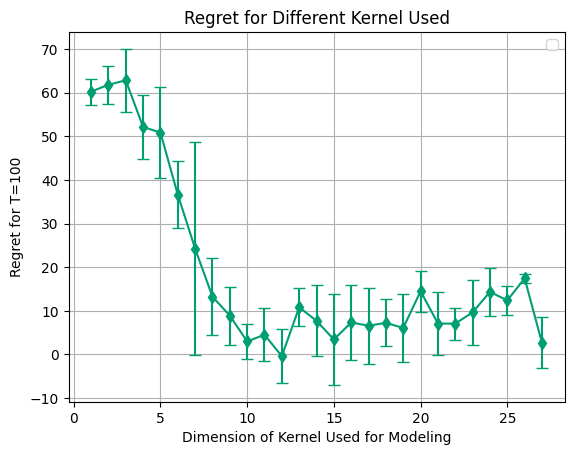

[np.float64(60.217037982812535), np.float64(61.77412658069588), np.float64(62.81133294185103), np.float64(52.12360976842086), np.float64(50.817097795717245), np.float64(36.618070382625376), np.float64(24.242126294987624), np.float64(13.242161459441393), np.float64(8.887576456606409), np.float64(2.9815411204406757), np.float64(4.518236368981172), np.float64(-0.38749639934640484), np.float64(10.814663500681077), np.float64(7.696212203483985), np.float64(3.4311790614189395), np.float64(7.329710157051333), np.float64(6.585741035529899), np.float64(7.240033304794777), np.float64(6.079738862667494), np.float64(14.488773331971002), np.float64(7.089571459298624), np.float64(7.05270383056886), np.float64(9.652898157931665), np.float64(14.32807551433554), np.float64(12.390310451456783), np.float64(17.430930548403353), np.float64(2.673873743399007)]
[np.float64(2.9748997986489325), np.float64(4.356874760163287), np.float64(7.18231341576539), np.float64(7.283894679175557), np.float64(10.4833548377

In [ ]:
w_random = np.array([1 for _ in range(27)])
# w_random = np.random.normal(loc=0.0, scale=sigma_w, size=27)

qubits = 3
seed = 1
bounds = [(0, 2*np.pi), (0, 2*np.pi),(0, 2*np.pi)]

quantum_f = lambda X: np.array([f_draw_from_GP(X[i]) for i in range(X.shape[0])])


dim_tried = []
regret_for_dim = []
std_regret_for_dim = []

for dim in trange(1,28,1, desc="Dimension of Kernel Used"):

  kernell = lambda X,Y: reduced_matrix_classic(X,Y,dim=dim)

  gp = GaussianProcessRegressor(kernel=kernell, alpha=1e-4)

  avg_best, best_hist_all,std_regret = run_multiple_experiments_gp_ucb(
  f=quantum_f,
  gp=gp,
  bounds=bounds,
  n_runs=30,
  n_iter=100,
  init_points=1,
  n_grid=5,
  beta_func=None,  # use the default inside gp_ucb_nd
  random_state=42,
  error = 3/dim,#get_max_error(dim),
  verbose=False
)

  dim_tried.append(dim)
  regret_for_dim.append(avg_best[-1]/6) #5.2
  std_regret_for_dim.append(std_regret[-1]/6)
  print(avg_best)


plt.errorbar(dim_tried,regret_for_dim,std_regret_for_dim,ls="-",
             marker='d',
             color="#009E73",
             alpha=1.0,
             capsize=4)
plt.title("Regret for Different Kernel Used")
plt.xlabel("Dimension of Kernel Used for Modeling")
plt.ylabel("Regret for T=100")
plt.grid(True)
plt.legend()
plt.show()


print(regret_for_dim)
print(std_regret_for_dim)

Dimension of Kernel Used:   4%|▎         | 1/27 [06:21<2:45:31, 381.98s/it]

[  4.46434802   8.26484143  12.8395501   17.15792632  21.86848087
  26.22310492  30.5313225   35.41508266  40.53462747  44.93361853
  49.33333642  52.35233037  57.02002773  61.67347029  65.93319962
  70.66051341  74.91135683  79.18907323  83.67752976  88.09812817
  93.10923531  97.49263187 102.38366237 106.54940896 110.16258172
 113.37616251 118.32216008 122.63079069 127.07603311 131.43990642
 134.96614354 137.45638338 141.91015045 146.51680484 150.63954162
 154.26095138 158.77301441 163.46056631 167.89590081 172.81402264
 177.45194969 181.56298147 185.472388   190.0495005  194.76965892
 198.43078676 203.41773742 207.94147448 211.77758874 215.37724413
 219.48124444 223.68299917 229.03285381 233.94867208 238.47880201
 243.52080751 245.99559748 250.84001337 254.42973273 259.19913695
 263.8439513  267.74543885 272.37425118 276.57424879 281.45210012
 285.31649676 289.6704421  292.60961744 297.07088717 299.75205314
 304.21537372 308.81195828 312.67867223 317.36427429 321.56528216
 326.16409


Dimension of Kernel Used:   7%|▋         | 2/27 [12:34<2:36:45, 376.22s/it]

[  4.35756614   8.44455101  12.03805669  16.45475337  20.98475247
  25.2689892   29.86246569  34.5898101   38.7143175   41.53087357
  45.81841861  50.50707352  55.24822614  59.39227922  63.25075117
  67.65777107  72.15398986  76.05274385  79.57054221  84.04327456
  88.17078182  92.66789661  97.1527054  101.95976436 106.53879765
 110.84794324 115.90114434 119.53288496 123.70401552 127.07773448
 130.12341172 134.57756376 139.189517   142.90216763 147.16421305
 150.38200474 154.77698595 157.65587028 161.58354182 166.13802233
 168.84214322 173.94716941 177.14715083 181.14771531 186.40203874
 190.31172266 192.93029172 196.88967356 198.16246849 203.06829692
 206.93691223 211.22500809 216.01847168 219.78958452 224.25330024
 227.16373412 232.06850636 236.44163419 239.99406041 243.97105057
 248.67614275 252.35989561 255.63706772 260.53230512 264.87463461
 269.42233548 273.94815837 278.11060915 280.44869649 285.23987986
 289.70309732 294.40712316 297.40166881 301.53991239 305.68317399
 310.05463


Dimension of Kernel Used:  11%|█         | 3/27 [23:24<3:20:31, 501.31s/it]

[  4.63341806   7.5370548   11.23118772  13.73661462  18.4424646
  20.49964071  24.50248964  26.91199469  29.96869944  33.01141388
  36.12841898  40.64426936  43.19917419  46.03520966  48.86534688
  52.81740785  57.132268    62.06331862  66.06763873  69.86361261
  74.58186418  78.27839777  83.34302573  88.19226677  92.12806201
  94.23793208  98.87017799 103.37641771 106.99867664 110.11234093
 113.19007705 117.57721395 121.65250485 125.99941706 129.38752074
 132.89741919 136.82364407 139.53171544 144.15898084 148.2198943
 152.58996706 157.14447507 161.33743811 165.73950566 170.32803336
 173.72343206 177.79331101 181.34884333 184.46566551 188.35617906
 192.74847363 193.82905648 197.47979136 200.02805028 203.47137708
 206.70289678 209.43458815 213.6185327  218.23588215 222.73281652
 226.69053349 229.87377183 233.37294247 237.77442423 242.14074049
 246.64092803 249.5498759  254.14270316 256.75150609 259.49150536
 264.02245372 265.74073215 269.58689363 271.32806269 275.42805495
 278.3669022


Dimension of Kernel Used:  15%|█▍        | 4/27 [34:09<3:33:57, 558.14s/it]

[  4.27961987   8.5469654   12.30485499  15.1786429   19.64666901
  23.87076067  26.96556014  31.58831251  35.72088161  39.04861697
  42.4688402   46.13214019  49.96542928  53.65288285  56.34512424
  60.41861048  65.3484836   69.29752643  72.56055405  76.73024965
  79.95383801  84.86117306  89.00057974  92.50452811  95.09860414
  99.71257988 103.91341461 106.95774624 109.73592619 114.66263609
 118.43942639 120.00953998 122.54386314 125.48083426 130.12165408
 133.88095373 135.91910864 139.30034605 143.78752322 147.79238524
 150.56516941 154.84679011 158.10824112 161.28916421 165.7130217
 169.30548589 173.68100533 177.66921157 182.09117859 185.7536133
 190.28975176 194.13919734 197.41521173 199.78410012 203.10352423
 206.85218467 208.78404247 211.76571964 214.39179986 215.87638944
 220.38132412 223.57400912 226.3630172  229.28070302 233.72363396
 237.25008807 240.66727958 243.07036121 246.02544602 249.93654567
 252.13523764 256.78449536 259.36019069 262.99357609 267.16418797
 271.7337018


Dimension of Kernel Used:  19%|█▊        | 5/27 [49:11<4:10:03, 681.99s/it]

[  4.30859535   8.64983142  11.95654209  16.16305918  18.3043318
  21.89454179  25.93903778  30.2855257   34.31580802  38.55887991
  41.31352043  45.1383396   49.023747    52.4006772   55.46053571
  58.77854003  61.37923872  65.56555291  69.0047154   71.46639284
  75.08130517  77.57399895  81.92467501  84.65739802  88.49863132
  92.81512715  96.01003732 100.06819596 103.1958465  106.75942569
 109.83640944 113.88551909 117.59404828 120.39268729 124.78538501
 128.91199776 130.78950561 132.72856797 136.75791374 139.22166748
 142.16814182 143.63729824 146.08573352 148.61485338 152.52096082
 156.90249442 159.18432762 162.26355204 165.89219844 169.7795502
 171.77278629 174.20825024 176.41556196 179.8836703  181.97783752
 185.59641674 188.03202065 192.24754517 195.6536137  199.76810838
 203.92182242 205.48217678 207.94310992 209.94289281 211.43815058
 215.00140073 218.12070413 222.46699834 227.0424847  228.68491415
 230.36223634 233.57634552 237.69967154 239.5932623  242.91098358
 244.5409259


Dimension of Kernel Used:  22%|██▏       | 6/27 [1:04:23<4:26:07, 760.37s/it]

[  4.82631169   9.01374757  13.68708203  16.91350205  21.46735224
  25.83135913  28.49577615  31.1451911   34.16741154  36.86786656
  41.07888233  44.76447103  49.04747129  51.83941314  54.8504208
  58.2822487   61.13482393  64.39232362  68.7907536   71.19298048
  74.42993303  76.5111775   78.78266287  82.7992895   87.00966051
  91.69665099  95.08786487  98.19397915 102.61967379 105.28952481
 109.07230344 112.56715302 115.48634135 119.69518929 124.41782862
 127.60755337 131.38312656 134.66932561 139.53849857 141.5121869
 145.60967079 148.70807717 152.38755891 156.01313663 160.32375991
 165.03540589 167.72443015 171.42794957 175.44033388 179.56446157
 184.28362059 187.73561442 192.34913047 195.42798854 199.33841739
 201.78273549 204.93502333 208.82100878 212.52570578 214.80910566
 218.8265958  220.90021863 223.87971703 225.88482228 230.91244249
 233.44230372 234.84066931 239.5512641  242.6049848  244.36601937
 249.28838119 250.5160241  253.74574503 256.77051843 259.41336391
 264.2877008


Dimension of Kernel Used:  26%|██▌       | 7/27 [1:23:44<4:57:03, 891.18s/it]

[  4.47047257   9.75592584  14.34806867  18.3501805   23.47071606
  27.33601588  31.42471759  35.27204805  39.32070264  43.02193324
  46.91829535  50.86383285  54.61044983  58.50093139  62.364941
  66.07790199  69.78389439  73.44214014  77.03782487  80.30546861
  83.57164945  86.77592627  89.59196843  92.51113886  95.13419355
  97.96647156 100.62363128 103.19905688 105.93337781 108.55097918
 111.51096744 113.68350804 116.47628707 119.24223464 121.77459441
 124.62701658 127.38375393 129.9700067  132.84678876 135.52428927
 138.02242937 140.44306298 142.82885698 145.13973564 147.23948304
 149.5984487  151.79684589 154.20631509 156.66782708 159.20393126
 161.65885752 163.83833178 166.66572804 169.13138437 171.48108124
 174.00485215 176.4846931  178.58790591 180.88631483 182.98297159
 185.12097609 187.42575035 189.77596828 191.74937646 193.80576533
 195.70821589 197.69036546 199.86565599 202.0883749  204.18493935
 206.27680444 208.15136667 210.20824371 212.27650741 214.26346378
 216.2040228


Dimension of Kernel Used:  30%|██▉       | 8/27 [1:43:15<5:10:27, 980.37s/it]

[ 4.15720677  8.28961054 12.42853987 16.55686659 20.11657917 23.36626444
 27.19577341 30.7499686  32.78057597 34.53255708 36.94729417 38.59341705
 40.42418245 41.82888325 43.79484205 45.70310294 47.26721244 48.56788648
 50.47362812 52.10944883 53.86740873 55.32156496 56.5674557  57.32869635
 58.10322887 58.42347542 58.75098181 58.80000273 58.96847039 59.09826452
 59.37834155 59.36478052 59.67021462 59.77104257 59.78167451 59.86132408
 59.89457578 60.20356649 60.32445229 60.61210898 60.98229095 61.17332946
 61.47668451 61.70925629 62.03004173 62.2416524  62.22833933 62.90139155
 63.10460498 63.13435711 63.28690397 63.15092395 63.26404649 63.36125827
 63.36493821 63.55677362 63.73747034 63.79349608 64.03540266 64.26496176
 64.17906134 64.30433014 64.36346644 64.55983211 64.64865276 64.57585664
 64.90564803 64.94025162 64.910377   65.13635699 65.44288725 65.71733776
 65.72543362 65.68717471 65.91411056 66.35005356 66.79133112 66.79957203
 66.77527296 67.17060195 67.70813962 67.83367477 68


Dimension of Kernel Used:  33%|███▎      | 9/27 [2:07:30<5:38:34, 1128.59s/it]

[ 4.17034075  8.33016986 12.58255733 15.36951608 18.24425879 20.56781025
 25.06415408 28.85421467 33.03166245 34.24206542 34.6610817  34.67228611
 34.95221173 35.17470518 35.17210555 35.26607635 35.18699302 35.65857288
 35.68587683 35.93172798 35.81329077 35.85737719 35.76808748 35.667199
 35.6598164  35.78215063 35.67810894 35.97491056 36.11400093 36.02842133
 36.0045196  35.91695115 35.98082309 35.81835763 35.69939839 35.83768857
 36.03417866 35.90256336 35.95750988 35.9334671  36.20909933 36.16060823
 36.13312535 36.07941354 36.02095635 36.2852016  36.51253042 36.40520596
 36.40559202 36.41922331 36.43728854 36.38595715 36.26471046 36.50707244
 36.40244842 36.38461979 36.2397693  36.35612629 36.37728142 36.37031507
 36.26284771 36.12097199 36.31469472 36.3878458  36.75927427 36.95463876
 36.95056356 37.00181392 37.15318419 37.21725131 37.19921988 37.2508933
 37.09238857 37.16217206 37.03526883 36.92264244 37.18909045 37.41932455
 37.28651349 37.57027842 37.65908929 37.66784477 37.86


Dimension of Kernel Used:  37%|███▋      | 10/27 [2:31:42<5:48:04, 1228.50s/it]

[ 1.43435042  4.53481827  6.47918207 10.36523536 12.41344144 15.2625138
 16.72068927 16.94845545 18.92610665 21.15187445 22.59542042 22.57939414
 22.4861766  22.59930398 22.80614601 22.73596387 22.73831961 22.83789469
 22.99357275 23.09592865 23.08218912 22.99121696 22.9944965  22.96469141
 22.8649011  23.08030665 23.21958114 23.16525048 23.29733455 23.41529431
 23.53070548 23.50236559 23.5212128  23.57928251 23.55353197 23.45972851
 23.28481675 23.28595588 23.50516443 23.71026748 23.73152862 24.27245611
 24.281484   24.21318357 24.18235038 24.09208594 24.06090559 24.10880997
 24.0516875  24.02370584 24.22823457 24.30405729 24.27838529 24.42317249
 24.40166066 24.42970077 24.43040043 24.4903157  24.47718012 24.38491956
 24.35154101 24.28011084 24.6181426  24.68779974 24.81062092 24.71479669
 24.58536697 24.74294654 24.67762487 24.67568472 24.69603493 24.89562172
 24.96389102 25.0155994  24.95291784 24.83395819 24.76999686 24.96336301
 24.92616343 24.76953948 24.70571109 24.67121999 24.


Dimension of Kernel Used:  41%|████      | 11/27 [3:00:35<6:08:46, 1382.93s/it]

[ 4.51657641  9.78151522 14.04425129 17.43977312 20.64194729 22.64789227
 27.31119402 29.74300572 33.9736264  37.14396018 41.50779809 45.51228018
 46.45716497 47.42981051 48.91944774 49.67000047 50.64123568 51.55852073
 52.20540032 53.08686385 54.08866413 54.73949523 55.82545896 56.39928312
 56.64286758 56.69401999 56.95693721 57.30998282 58.05386507 58.21795964
 58.72842122 59.33660589 59.74580328 60.24077885 60.2473005  60.40069175
 60.55321633 60.68733605 60.80690788 60.97075857 61.10980986 61.25673655
 61.34510745 61.5170619  61.69907512 61.97176955 62.03905012 62.12247831
 62.27015275 62.52269268 62.56836777 63.13753725 63.15117998 63.37742131
 63.44374991 63.69063043 63.7591991  63.8575469  63.94014763 64.1549583
 64.36603948 64.74484518 64.86588194 65.10582369 65.17369668 65.16522896
 65.27875368 65.41579986 65.67752636 65.91047891 65.92504158 66.31656661
 66.49532907 66.70314878 66.72478684 66.76234154 66.77662774 67.25920652
 67.59897571 67.87992085 68.08368294 68.41809464 68.


Dimension of Kernel Used:  44%|████▍     | 12/27 [3:29:31<6:12:34, 1490.32s/it]

[ 3.90034245  8.36275897 12.93397126 16.24133076 17.43424843 19.57311083
 23.30026648 24.34243992 27.25287238 29.90331467 32.05591461 33.99565733
 34.25256669 34.77755786 34.77272865 34.8667838  34.99085679 35.31390045
 35.54122336 35.76213353 36.04514566 36.32877982 36.66302479 37.12685999
 37.404158   37.6721063  38.16241729 38.23896634 38.30222668 38.74972566
 38.94662932 39.21974554 39.33196716 39.49175161 39.68924997 39.99332247
 40.2222035  40.34845937 40.57832494 40.78823967 41.24210617 41.51822736
 42.04869737 42.19647597 42.30654677 42.87103698 42.96864082 42.98214112
 43.13516313 43.2528293  43.32220021 43.48157973 43.76558712 43.84403515
 43.98416786 44.18797438 44.50372484 44.56031422 44.77252102 44.82657486
 45.17010447 45.47184872 45.70523718 45.71900242 45.89951489 46.09246939
 46.1900859  46.17883902 46.20221173 46.23452379 46.33082077 46.53065274
 46.82689545 46.90534103 47.11569316 47.2722714  47.53203728 47.52504404
 47.76810324 47.80074759 47.84982681 47.94041818 47


Dimension of Kernel Used:  48%|████▊     | 13/27 [4:02:44<6:23:17, 1642.67s/it]

[ 3.96603973  8.30824124 12.91594215 17.4212065  21.44048323 25.93655488
 29.50437842 33.35510688 37.83627518 40.70099617 43.30308855 45.42032535
 48.33428964 49.74829041 51.61052775 52.5138845  53.77329015 54.53596865
 55.24323008 55.62854617 55.9120026  56.38157987 56.41129373 56.94616939
 57.0044767  57.06772098 57.19976382 57.84869922 57.77017903 58.00700655
 58.03397071 58.18104545 58.1736779  58.21158212 58.06012629 58.50090685
 58.59271657 58.50908188 58.71184916 59.05105171 58.81133166 59.07375271
 58.95275396 59.0315423  59.38579138 59.48222366 59.57114028 59.7648188
 59.80554026 59.78486217 59.72823908 59.75709306 59.84943479 59.85997299
 59.94611697 59.80021449 59.7727902  59.89588048 59.88646076 59.93968399
 59.93632815 59.86499032 59.63082878 59.62200793 59.57411102 59.65892078
 59.61284304 59.69113984 59.70658376 59.58928852 59.45468146 59.56272123
 59.65856054 59.5044414  59.30998698 59.31260032 59.20278909 59.1940157
 59.19176527 59.27349264 59.01126551 58.86761762 58.7


Dimension of Kernel Used:  52%|█████▏    | 14/27 [4:35:57<6:18:50, 1748.50s/it]

[ 3.46908093  7.49941953 11.47261855 14.04950693 17.86497289 21.7916188
 23.42108217 26.01131202 29.40632494 31.54954418 33.75206217 36.21628223
 38.28744972 39.46506635 40.74020128 41.42674629 41.74604904 42.17971557
 42.44088772 43.08983076 45.27522116 45.32162965 45.29012161 45.5632101
 45.61471808 45.65440996 45.54217785 45.71975155 45.68789828 45.69894015
 45.70565091 45.78832962 45.96075443 45.94738034 46.00736606 45.95928755
 45.89223516 45.77654479 45.95213452 46.33325603 46.33374302 46.28640073
 46.24261094 46.52844095 46.5155649  46.56341149 46.54695921 46.61518241
 46.76336186 46.93605956 47.09177047 47.0331353  47.31014626 47.47032616
 47.49602555 47.4409531  47.36727068 47.49126085 47.58669621 47.52191261
 47.78040371 47.73009648 47.89763052 47.99098998 48.02906591 48.20454349
 48.48630287 48.69475146 48.75530188 48.89183721 49.10588636 49.19337145
 49.18561119 49.24010652 49.27072115 49.27547377 49.3852658  49.37459241
 49.29833517 49.3559897  49.41846741 49.45007165 49.4


Dimension of Kernel Used:  56%|█████▌    | 15/27 [5:13:23<6:19:41, 1898.44s/it]

[ 3.20613849  7.6005021   9.89615272 13.22787577 16.61307488 18.91850745
 19.31439163 20.52155643 21.2866826  22.67057408 24.79682001 29.34068357
 31.75349008 33.51911232 33.52951489 38.44333247 40.24572144 40.32763197
 40.50691953 40.63898635 40.89823537 40.9811632  41.18195126 41.18533717
 41.20106488 41.2053121  41.57715462 41.58952033 43.57350327 43.8536758
 44.0846104  44.26137435 44.44909137 44.72516058 44.76057132 45.14216414
 45.2547351  45.27839645 45.37240292 45.5640859  45.83778597 45.89831045
 46.14091455 46.36601921 46.38166976 46.56789901 46.61382911 46.74250064
 46.77708382 46.79762173 47.05624139 47.23759841 47.27294896 47.58143606
 47.6041065  47.68857204 47.75933515 47.82173702 47.9146578  47.93209119
 47.94822932 48.16971918 48.21195141 48.5105965  48.50772798 48.78487169
 48.91652094 48.98297283 49.04935777 49.12952811 49.27282617 49.36395577
 49.39013725 49.37886193 49.51101732 49.56226904 49.67258205 49.79439795
 50.05516578 50.2264879  50.42878696 50.51767194 50.


Dimension of Kernel Used:  59%|█████▉    | 16/27 [5:50:49<6:07:15, 2003.19s/it]

[ 4.90390349  7.24143933  9.78960891 12.37535599 13.49867357 14.58613856
 16.9556021  18.04915428 18.85304385 21.03260235 26.00054176 28.02760754
 29.84665366 32.28227475 34.7111482  37.1523647  39.22463254 41.62129156
 41.59569453 41.56631069 41.52754623 41.6602368  41.91218985 41.95809531
 42.08908528 42.0338828  42.45525692 42.37538496 42.44507006 42.41888592
 42.70395571 42.73775015 42.78663702 42.77069875 42.94655118 43.11226456
 43.12257748 43.06936784 43.14449465 43.16517804 43.16217988 43.11615248
 43.13138224 43.20287971 43.32981952 43.33005023 43.34179578 43.49063543
 43.45856052 43.69719813 43.66133773 43.76070946 43.80344289 43.94636595
 43.98776216 43.98710262 44.00091913 43.95596818 44.00516871 44.1044398
 44.30132207 44.24007869 44.45303071 44.46204687 44.35995551 44.45951933
 44.47587608 44.47068434 44.54195857 44.67526705 44.75149087 44.77183741
 44.66865982 44.82927042 44.86099778 44.93174118 44.9610638  45.10544057
 45.03138857 44.97920348 45.02157773 45.0968988  45.


Dimension of Kernel Used:  63%|██████▎   | 17/27 [6:32:45<5:59:32, 2157.28s/it]

[ 4.37949703  8.89098121 13.72807094 17.06109718 21.20407243 23.96439276
 25.6145274  26.21382627 26.48544822 27.62772484 27.88628247 27.8875806
 28.07770298 32.28586975 34.53444954 37.24462253 37.25708582 39.78227758
 42.17721287 42.21186069 42.25267782 42.29420487 42.49039023 42.55914562
 44.45429964 44.5551916  44.72804328 44.77744384 44.82208766 44.87673458
 45.03160648 44.99595321 45.14340729 45.0720571  45.02505781 45.10650887
 45.06381255 44.98646733 44.91717299 45.10930863 45.00088409 45.17308443
 45.23929408 45.33339733 45.32303425 45.40381422 45.51668317 45.54434232
 45.70086809 45.75937316 46.09421501 46.20580016 46.3598548  46.28459452
 46.22941818 46.39196295 46.32175689 46.45731577 46.42691375 46.40171483
 46.43354766 46.41856919 46.43702947 46.4162858  46.34123933 46.26867581
 46.25898608 46.38799865 46.53411968 46.6123016  46.6557096  46.74947982
 46.88964223 46.94521262 46.88669505 46.88084937 46.86775321 47.07749785
 47.11225161 47.24934952 47.26294371 47.42246505 47.


Dimension of Kernel Used:  67%|██████▋   | 18/27 [7:14:42<5:39:49, 2265.48s/it]

[ 4.13526052  7.86033894 11.64511283 16.9164832  21.38875054 24.77885248
 27.68116196 30.84691058 33.8726363  34.11533289 35.69643674 36.13937625
 37.44312305 37.51071397 37.73282001 40.23709184 42.55398229 42.57707527
 42.60440821 42.61217489 42.6448433  42.64646097 42.63473994 42.54481351
 42.52887117 42.46240645 42.3920247  42.40917228 42.33556342 42.81796435
 42.84442203 43.10771656 43.24352547 43.34588829 43.32015298 43.37776448
 43.43271561 43.40305743 43.44725093 43.35661767 43.35013201 43.44154604
 43.51497235 43.4066824  43.44090743 43.54773319 43.52482896 43.48003797
 43.62270922 43.67908568 43.69257263 43.71415448 43.65761255 43.67595194
 43.89149186 44.00340721 44.21057321 44.16171662 44.06067044 43.99316921
 43.93785555 43.88099984 43.81835183 43.6789188  43.6495005  43.65916342
 43.70218929 43.77747738 43.78444868 43.97018278 44.01076845 44.14362319
 44.19238349 44.30617157 44.39852006 44.26563617 44.55516832 44.49556616
 44.45372026 44.35701238 44.41929269 44.59585554 44


Dimension of Kernel Used:  70%|███████   | 19/27 [8:01:13<5:23:05, 2423.18s/it]

[ 4.239534    7.3054003  10.3854453  12.86251894 15.60609323 18.30177617
 21.67026012 23.66067693 26.09107171 26.44931505 27.11385542 27.7907006
 29.15807415 29.31851019 31.51427209 33.92923966 36.39000007 39.00387256
 41.2066712  41.34605135 42.68054054 42.66730055 42.75555679 42.88324933
 42.93858216 42.98161602 43.431187   43.59796211 43.72959507 43.90511053
 43.99588781 44.03470757 44.28912156 46.5082684  46.64856396 46.62357642
 46.73002804 46.83928541 46.98325565 47.08927244 47.28452112 47.50967416
 47.65767742 47.87687655 47.84776552 47.90117037 48.00638051 48.23937191
 48.42122678 48.51129628 48.5997676  48.7761474  48.82447339 48.83569345
 48.92536847 49.11521994 49.33697224 49.53457747 49.66520066 49.73794209
 49.96116546 50.00509859 50.1045993  50.38778342 50.55933247 50.63163603
 50.67892868 50.84514097 51.1741922  51.26449622 51.46310124 51.60032924
 51.88430445 52.03315963 52.03919545 52.01894644 52.13015855 52.26361674
 52.30220098 52.38994617 52.44540617 52.62109633 52.


Dimension of Kernel Used:  74%|███████▍  | 20/27 [8:47:41<4:55:29, 2532.76s/it]

[ 4.21124274  8.82685396 13.26536299 18.00957639 20.83217351 23.31325095
 27.27116016 27.63774139 29.03558283 31.11422147 32.82907153 32.9471
 35.35355142 35.47634919 37.61153347 38.78750355 41.05777282 43.23359996
 45.31577245 47.08880537 51.37405328 51.40186817 53.65328843 53.53657985
 53.55990678 53.43882232 53.74138095 53.66876323 53.52286757 53.47600242
 53.25890461 53.19905567 53.10272827 52.94483504 53.03434416 52.92115203
 52.92447735 52.87374057 52.7946065  52.77120227 52.74026195 52.57993967
 52.42886378 52.31894548 52.21336273 52.09480685 52.1652983  52.07571407
 52.0762897  52.09813554 52.05638886 52.12862693 52.02431851 52.11338056
 52.02687275 51.93352405 51.95713536 51.8031267  51.63355351 51.56508979
 51.52965532 51.497555   51.43358165 51.38901471 51.25560879 51.23772877
 51.21325547 51.2116581  51.28991228 51.18672446 51.03962072 50.9823627
 50.95856109 50.84061815 50.8903266  50.77727943 50.77006536 50.69071271
 50.61357674 50.67394995 50.6696192  50.54565811 50.4624


Dimension of Kernel Used:  78%|███████▊  | 21/27 [9:38:56<4:29:33, 2695.55s/it]

[ 3.82728349  6.72501589 10.11255531 14.63109371 16.34030868 20.19879231
 20.39361612 22.20416989 23.72499665 23.83988321 24.41868676 26.57769605
 26.95373016 29.35307941 33.46555172 36.2701082  40.76028402 40.72651549
 40.66548606 43.19514909 45.15550369 47.3515574  49.67354375 49.62943888
 49.52914533 49.66541779 49.75482754 51.92826865 53.97334448 54.23701614
 54.15747643 54.29547655 54.26399242 54.41670476 54.37279717 54.31151057
 54.33117044 54.43360233 54.40774546 54.43879482 54.51713249 54.67759807
 54.6177392  54.79887871 54.7810792  54.69688018 54.92321464 54.83855602
 54.89009319 54.7541147  54.70873086 54.69782778 54.76049599 54.86906528
 54.85369701 54.82385473 54.84586879 54.78447693 54.91244971 54.83958301
 54.75615782 54.83379674 55.09569546 55.35560584 55.22904604 55.33966027
 55.341189   55.34306539 55.46835917 55.5995157  55.58506232 55.59872474
 55.59421737 55.51233216 55.60707321 55.58300511 55.56585045 55.5429085
 55.59103862 55.48962636 55.47341748 55.43337298 55.


Dimension of Kernel Used:  81%|████████▏ | 22/27 [10:30:32<3:54:39, 2815.81s/it]

[ 4.82365376  9.74482624 13.06431639 15.78333598 19.60913355 21.73984377
 25.30693737 28.0466664  28.92210797 29.5584332  29.93037766 30.34827899
 33.04247309 33.42294614 35.62186491 37.76809533 40.60342205 42.79464767
 43.02919837 43.16688082 43.29555159 43.65383812 45.59150505 45.6700052
 45.85187545 46.12371032 48.70528509 48.80419002 48.90169036 49.06858498
 49.13765608 49.37547097 49.84918983 49.87632658 50.07220793 50.24363106
 50.37883329 50.53514839 50.75012523 50.83559809 50.94518961 51.04132538
 51.31783346 51.40927259 51.58087563 51.64640013 51.74761471 51.84003205
 52.04080132 52.26816169 52.34460085 52.43986152 52.58889006 52.79137873
 53.02539591 53.19695462 53.27975511 53.48085748 53.4912602  53.54615512
 53.62924469 53.75714774 53.82924902 53.86021649 53.99367841 54.14417136
 54.31610684 54.38812853 54.45528228 54.53085988 54.62669225 54.76156689
 54.88582072 54.86621088 54.98336939 54.97737273 55.03512941 55.03064318
 55.10593181 55.40047431 55.53872388 55.62646294 55.


Dimension of Kernel Used:  85%|████████▌ | 23/27 [11:27:13<3:19:24, 2991.22s/it]

[ 3.67003587  6.63965496  9.06419964 12.4166132  14.75454607 17.46086912
 21.33482185 22.10899359 23.05599957 24.19838326 24.23159683 24.40178904
 26.8903612  29.22735176 29.31599335 31.52549372 34.02712554 36.18793476
 36.36310487 36.36176885 38.6918276  39.12251982 43.39928213 45.45454246
 45.67783113 45.83340885 48.42254416 48.44723171 48.47089934 50.81296007
 50.94310671 53.73680506 53.71479982 54.18204927 54.5048647  54.5381128
 54.59589282 54.5933276  56.67121687 56.95326742 57.06115992 57.11059903
 57.18871274 57.19950868 57.19662875 57.27539821 57.47213126 57.6010299
 57.63903683 57.72424203 57.73150904 57.91584322 57.92198956 58.13388778
 58.27957826 58.32908    58.41725779 58.39146783 58.65322097 58.61878514
 58.62390865 58.65544264 58.7601627  58.93099179 59.17088742 59.19480365
 59.23164429 59.39143449 59.65807193 59.61766229 59.78524672 60.11793115
 60.12415909 60.14876816 60.43755594 60.38413952 60.34107242 60.32310046
 60.48293728 60.57596253 60.58032167 60.67937299 60.7


Dimension of Kernel Used:  89%|████████▉ | 24/27 [12:23:37<2:35:27, 3109.01s/it]

[ 3.94952883  8.9831443  12.4281195  16.26485868 18.57821707 22.20397405
 24.82409808 28.37151733 31.59718982 33.49170804 33.80903554 34.52303886
 34.75076166 37.4067807  40.77654818 41.34591333 43.38106983 46.34505678
 48.61390331 50.78898008 52.82251399 52.93019819 55.23559607 58.05009902
 60.32112736 60.41055047 60.43136505 60.47595971 60.63611524 60.55099471
 60.74344629 60.69135051 60.72405346 60.751436   60.87415528 60.87371963
 60.91812665 61.02619385 61.15102307 61.23392377 61.22806553 61.21566883
 61.20640836 61.26351617 61.43596681 61.51244242 61.52501259 61.46297126
 61.43349766 61.47474706 61.69214984 61.858631   61.81231731 62.0524456
 62.01322627 62.14641598 62.32737187 62.4283764  62.61749449 62.74554356
 62.84289468 62.75792371 62.99361092 62.9747278  62.94926583 62.96430287
 63.35017359 63.51743004 63.79512835 63.73422264 63.90140601 63.99910858
 64.06259401 64.10904417 64.1314052  64.2766757  64.29666958 64.27317592
 64.29868002 64.33579236 64.35518425 64.47442237 64.


Dimension of Kernel Used:  93%|█████████▎| 25/27 [13:25:09<1:49:28, 3284.08s/it]

[ 3.90527406  8.73860264 13.08475085 17.60486098 20.45617049 24.39656915
 25.12443547 26.37937973 26.73802562 27.50811786 27.74064544 28.62729186
 28.84238998 28.8764963  33.00174525 35.40342602 37.64199114 37.79420186
 37.72491399 40.35206255 42.14203609 44.14713519 44.10805035 44.55825121
 44.53294943 46.79433153 46.69187299 46.72961243 49.00147786 51.0158904
 51.18094972 51.2302875  51.11213223 51.09872095 53.44843308 53.47408812
 53.36388546 53.42206521 53.38333171 53.39487101 53.40545002 53.39542786
 53.42657057 53.40163969 53.390541   55.43955635 55.3712426  55.23998399
 55.16493169 55.2344575  55.15064432 57.46152458 57.61777065 59.91138741
 59.91879757 59.87539762 59.76966717 59.78493704 59.66475122 59.58496683
 59.71423594 59.79191727 59.86033759 59.79954137 59.84082605 59.84997566
 59.90168734 59.95829821 59.98255747 59.88732044 59.9114323  59.91897911
 60.04829977 60.03035459 60.13324933 60.13924256 60.24867995 60.1590618
 60.08154245 59.99526547 60.08984967 60.20220067 60.1


Dimension of Kernel Used:  96%|█████████▋| 26/27 [14:27:03<56:53, 3413.05s/it]  

[ 4.45248042  7.52640774 10.19915495 11.50492084 12.36327945 14.02380751
 14.90461142 15.86137795 16.4193262  16.91205267 17.13622297 17.35684892
 17.46573484 19.8837485  24.42857504 26.50797515 26.4979344  31.31194796
 36.25337228 38.52272175 40.94701978 41.16579842 41.4396827  41.56068527
 43.92928495 43.98303782 46.32072423 48.38480005 50.82568398 53.02921559
 55.39452253 55.41828763 55.476395   55.45607609 55.60955395 55.72917141
 55.73041957 57.80559172 59.91461296 60.00118193 60.25739654 60.3818755
 60.35704128 60.47755303 60.67274536 60.80493163 60.90340747 60.90406559
 61.04003367 61.09486399 61.18257718 61.26565252 61.27929504 63.38596608
 63.50267824 63.63549374 63.81979264 63.82904648 63.78855512 64.0192808
 64.05148432 64.06689106 64.00809247 64.01997822 64.33583426 64.39042043
 64.38079687 64.36356098 64.47515322 64.5413009  64.55650351 64.58523661
 65.02324255 64.95592719 65.09070748 65.05580977 65.09405902 65.08060856
 65.18146119 65.30921457 65.29530444 65.41522046 65.5


Dimension of Kernel Used: 100%|██████████| 27/27 [15:33:25<00:00, 2074.27s/it]
<ipython-input-10-cf616a6bf6d7>:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


[ 1.59821093  3.97127254  4.93421323  7.65374389  8.10070616  9.15394639
  9.97331937  9.92932172 10.98329987 11.23123419 11.20407498 11.3355439
 14.30788271 16.28475106 17.79046551 19.91332961 19.96448393 22.07669194
 22.08369728 22.40412596 25.1434504  25.32650412 27.61032899 31.74223813
 31.8510241  33.97553961 36.34944241 40.63427221 40.66884013 42.79016678
 42.6870093  42.65981595 42.61874729 42.48772986 44.63016968 44.59075227
 46.80133715 51.07511623 51.06775367 51.18088769 51.28898456 53.37625193
 55.68887371 55.60679071 57.82893526 60.10382301 60.17529739 60.19772164
 60.28953164 60.31900004 60.4273619  60.37810695 60.38897508 60.42092622
 60.3999952  60.32807337 60.33250331 60.38983897 60.31754288 60.59408595
 60.62000876 63.17497507 63.31378469 63.31600601 63.30582343 63.37531325
 63.47687977 63.55404507 63.49609073 63.37959058 63.3220179  63.3721392
 63.2852629  63.3871275  63.52952446 63.59532172 63.64049165 63.58674194
 63.47263214 63.52574671 63.42923021 63.40622382 63.4

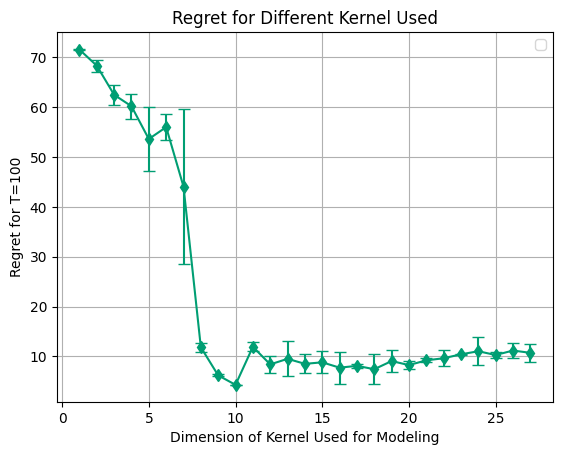

[np.float64(71.5874769978086), np.float64(68.35427573731882), np.float64(62.51092591824359), np.float64(60.217541104304466), np.float64(53.6370373652874), np.float64(56.029336207183896), np.float64(44.0955881687091), np.float64(11.840899849332445), np.float64(6.198112275765795), np.float64(4.301206118605723), np.float64(11.938635320211773), np.float64(8.400668198843718), np.float64(9.521526941930185), np.float64(8.513131904565723), np.float64(8.81667333925159), np.float64(7.743470331476604), np.float64(8.11230749880467), np.float64(7.435041550208491), np.float64(9.069733301427247), np.float64(8.264199524623878), np.float64(9.21416842504091), np.float64(9.634260204278322), np.float64(10.427730833009651), np.float64(11.037512985085213), np.float64(10.286021264037187), np.float64(11.182307016460406), np.float64(10.720647809511762)]
[np.float64(0.1339867505921101), np.float64(1.2419933862558423), np.float64(2.03595556197214), np.float64(2.489641387353449), np.float64(6.412631159280011), np

In [ ]:
# should give a reasonable plot

w_random = np.array([1 for _ in range(27)])
# w_random = np.random.normal(loc=0.0, scale=sigma_w, size=27)

qubits = 3
seed = 1
bounds = [(0, 2*np.pi), (0, 2*np.pi),(0, 2*np.pi)]

quantum_f = lambda X: np.array([f_draw_from_GP(X[i]) for i in range(X.shape[0])])


dim_tried = []
regret_for_dim = []
std_regret_for_dim = []

for dim in trange(1,28,1, desc="Dimension of Kernel Used"):

  kernell = lambda X,Y: reduced_matrix_classic(X,Y,dim=dim)

  gp = GaussianProcessRegressor(kernel=kernell, alpha=1e-4)

  avg_best, best_hist_all,std_regret = run_multiple_experiments_gp_ucb(
  f=quantum_f,
  gp=gp,
  bounds=bounds,
  n_runs=2,
  n_iter=100,
  init_points=1,
  n_grid=10,
  beta_func=None,  # use the default inside gp_ucb_nd
  random_state=42,
  error = 1/dim,#get_max_error(dim),
  verbose=False
)

  dim_tried.append(dim)
  regret_for_dim.append(avg_best[-1]/6) #5.2
  std_regret_for_dim.append(std_regret[-1]/6)
  print(avg_best)


plt.errorbar(dim_tried,regret_for_dim,std_regret_for_dim,ls="-",
             marker='d',
             color="#009E73",
             alpha=1.0,
             capsize=4)
plt.title("Regret for Different Kernel Used")
plt.xlabel("Dimension of Kernel Used for Modeling")
plt.ylabel("Regret for T=100")
plt.grid(True)
plt.legend()
plt.show()


print(regret_for_dim)
print(std_regret_for_dim)

## plot final

domain:[0,2pi]^3

grid_size=10,

T=100,

30 runs

In [ ]:
y2 = [np.float64(71.5874769978086), np.float64(68.35427573731882), np.float64(62.51092591824359), np.float64(60.217541104304466), np.float64(53.6370373652874), np.float64(56.029336207183896), np.float64(44.0955881687091), np.float64(11.840899849332445), np.float64(6.198112275765795), np.float64(4.301206118605723), np.float64(11.938635320211773), np.float64(8.400668198843718), np.float64(9.521526941930185), np.float64(8.513131904565723), np.float64(8.81667333925159), np.float64(7.743470331476604), np.float64(8.11230749880467), np.float64(7.435041550208491), np.float64(9.069733301427247), np.float64(8.264199524623878), np.float64(9.21416842504091), np.float64(9.634260204278322), np.float64(10.427730833009651), np.float64(11.037512985085213), np.float64(10.286021264037187), np.float64(11.182307016460406), np.float64(10.720647809511762)]
std_y2 = [np.float64(0.1339867505921101), np.float64(1.2419933862558423), np.float64(2.03595556197214), np.float64(2.489641387353449), np.float64(6.412631159280011), np.float64(2.566475526617604), np.float64(15.597543501750662), np.float64(0.8790915811423522), np.float64(0.18927393940180556), np.float64(0.02005942588279641), np.float64(0.9251614022860236), np.float64(1.719659691767123), np.float64(3.5394413062648034), np.float64(1.9291130263585667), np.float64(2.231945211368051), np.float64(3.2439316620078027), np.float64(0.3999903205825485), np.float64(3.0525333542203636), np.float64(2.2711616257584075), np.float64(0.8773118705086608), np.float64(0.38377325668371576), np.float64(1.5648068649296565), np.float64(0.1026435529960364), np.float64(2.8245452270170364), np.float64(0.6587153700929088), np.float64(1.5420737687943482), np.float64(1.8249635139928035)]

In [ ]:
import numpy as np
x = np.array([i for i in range(1,28,1)])
y = np.array([np.float64(69.52018593315273), np.float64(66.28161091525327), np.float64(58.109750265252735), np.float64(25.833972520859792), np.float64(18.865532533053965), np.float64(6.638831758566418), np.float64(8.389176010522446), np.float64(7.45954822334794), np.float64(8.909203878075974), np.float64(8.569775138152042), np.float64(9.756145604663951), np.float64(8.519012356966949), np.float64(9.959892396185792), np.float64(10.624303251940702)])
std_y=np.array([np.float64(5.134469641379388), np.float64(6.105115612731885), np.float64(8.826311429753963), np.float64(7.463804449756505), np.float64(10.349784789105666), np.float64(2.20541168012209), np.float64(1.47747504312939987), np.float64(1.2730215137753773), np.float64(1.9203658670283055), np.float64(1.9933669570230658), np.float64(2.0745700324959615), np.float64(3.10954728663232), np.float64(3.1957884021669702), np.float64(2.2007339875332663)])

# Final Plot and data

In [ ]:
y = np.array([70.55383147, 67.31794333, 64.39626842, 59.16364568, 55.87339382,
       40.93165436, 34.96478034, 15.35321619, 12.5318224 ,  8.47001894,
        8.28873354,  8.3949221 ,  7.95535148,  7.98634006,  8.13811078,
        8.3263371 ,  8.41075569,  8.20240834,  8.81975422,  9.01017256,
        9.38515701,  9.07663628,  9.47337159, 10.29870269, 10.12295683,
       10.80330513, 10.97247553])

std_y = np.array([ 2.6342282 ,  3.6735545 ,  4.07053559,  5.65797641,  7.61947129,
        5.01513999, 6.53067398,  5.61443819,  5.26952936,  1.11273555,
        1.56528654,  1.59856737,  2.50845817,  1.60106727,  1.75248336,
        2.58214876,  1.16017809,  2.52295016,  2.13226429,  1.47594095,
        1.22917164,  2.33717708,  1.60609542,  3.01016681,  1.92725189,
        1.87140388,  2.01284875])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

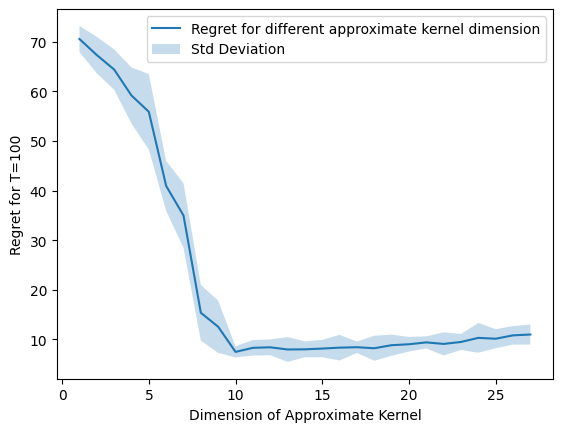

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Example data
# x = np.linspace(0, 10, 50)
# y = np.sin(xa)
# std_y = 0.2 * np.ones_like(x)  # just an example constant std

# Plot the main line
plt.plot(x, y, label="Regret for different approximate kernel dimension")

# Fill the error region
plt.fill_between(x, y - std_y, y + std_y, alpha=0.25, label="Std Deviation")
#plt.axvline(x=10, color='r', linestyle='--', label="Theoretical Optimal x")
# Add labels and legend
plt.xlabel("Dimension of Approximate Kernel")
plt.ylabel("Regret for T=100")
plt.legend()

# Save the plot to a file
plt.savefig("exp1_rff.png", dpi=300)
files.download("exp1_rff.png")


# MSE for different kernel dimension

Dimension of Kernel Used: 100%|██████████| 14/14 [00:13<00:00,  1.01it/s]
<ipython-input-105-5fb7184156fe>:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


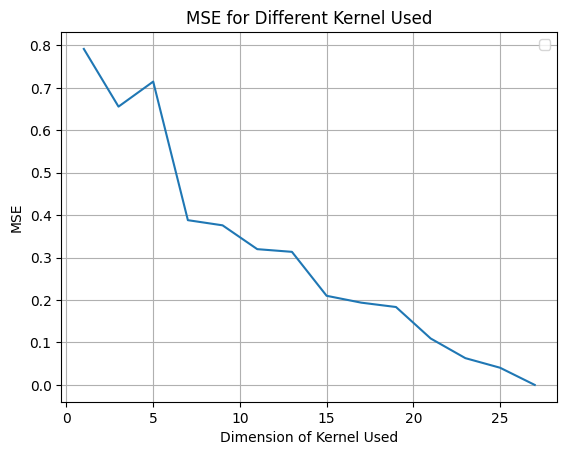

In [ ]:
w_random = np.array([1 for _ in range(27)])
#np.random.normal(loc=0.0, scale=sigma_w, size=27)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

dim_tried = []
mse_for_dim = []

quantum_f = lambda X: np.array([f_draw_from_GP(X[i]) for i in range(X.shape[0])])


for dim in trange(1,28,2, desc="Dimension of Kernel Used"):

  kernell = lambda X,Y: reduced_matrix_classic(X,Y,dim=dim)
  gp = GaussianProcessRegressor(kernel=kernell, alpha=1e-5)

  X = np.random.uniform([0]*3, [2 * np.pi]*3, size=(300, 3))
  true_y = quantum_f(X)
  y = true_y
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

  gp.fit(X_train, y_train)
  y_pred, std = gp.predict(X_test, return_std=True)

  dim_tried.append(dim)
  mse_for_dim.append(mean_squared_error(y_test, y_pred))


plt.plot(dim_tried, mse_for_dim)
plt.title("MSE for Different Kernel Used")
plt.xlabel("Dimension of Kernel Used")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()

Dimension of Kernel Used:   7%|▋         | 1/14 [00:00<00:02,  6.17it/s]

1
1
1
3


Dimension of Kernel Used:  14%|█▍        | 2/14 [00:00<00:03,  3.84it/s]

3
3
5


Dimension of Kernel Used:  21%|██▏       | 3/14 [00:00<00:03,  3.01it/s]

5
5
7
7
7


Dimension of Kernel Used:  29%|██▊       | 4/14 [00:01<00:03,  2.52it/s]

9
9


Dimension of Kernel Used:  36%|███▌      | 5/14 [00:02<00:05,  1.68it/s]

9
11
11


Dimension of Kernel Used:  43%|████▎     | 6/14 [00:03<00:06,  1.18it/s]

11
13
13


Dimension of Kernel Used:  50%|█████     | 7/14 [00:04<00:06,  1.11it/s]

13
15
15


Dimension of Kernel Used:  57%|█████▋    | 8/14 [00:05<00:05,  1.13it/s]

15
17
17


Dimension of Kernel Used:  64%|██████▍   | 9/14 [00:06<00:04,  1.11it/s]

17
19
19


Dimension of Kernel Used:  71%|███████▏  | 10/14 [00:07<00:03,  1.06it/s]

19
21
21


Dimension of Kernel Used:  79%|███████▊  | 11/14 [00:08<00:02,  1.00it/s]

21
23
23


Dimension of Kernel Used:  86%|████████▌ | 12/14 [00:09<00:02,  1.06s/it]

23
25
25


Dimension of Kernel Used:  93%|█████████▎| 13/14 [00:11<00:01,  1.13s/it]

25
27
27


Dimension of Kernel Used: 100%|██████████| 14/14 [00:12<00:00,  1.12it/s]

27



<ipython-input-96-13f486786c9d>:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


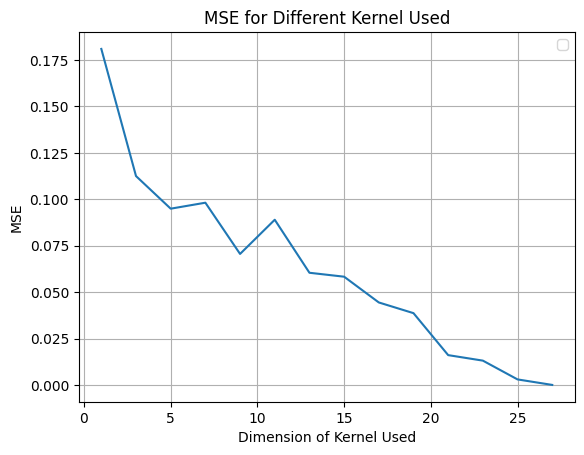

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

dim_tried = []
mse_for_dim = []

quantum_f = lambda X: np.array([f_draw_from_GP(X[i]) for i in range(X.shape[0])])


for dim in trange(1,28,2, desc="Dimension of Kernel Used"):

  kernell = lambda X,Y: reduced_matrix_classic(X,Y,dim=dim)
  gp = GaussianProcessRegressor(kernel=kernell, alpha=1e-5)

  X = np.random.uniform([0]*3, [2 * np.pi]*3, size=(300, 3))
  true_y = quantum_f(X)
  y = true_y
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

  gp.fit(X_train, y_train)
  y_pred, std = gp.predict(X_test, return_std=True)

  dim_tried.append(dim)
  mse_for_dim.append(mean_squared_error(y_test, y_pred))


plt.plot(dim_tried, mse_for_dim)
plt.title("MSE for Different Kernel Used")
plt.xlabel("Dimension of Kernel Used")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
diagK = np.array([1,2,34])
math.sqrt(diagK[i1]) if diagK[i1] > 1e-14 else 1e-14

NameError: name 'i1' is not defined